In [1]:
%matplotlib inline

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html
    
working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

Wrong working directory
/Users/carlos/Documents/LeTaffe/PROJET_ESSAI
New directory : /Users/carlos/Documents/LeTaffe/PROJET_ESSAI


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.mel_model import mel_model
from utilsFunc import *

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

imports done
parsing variables...
Using : cuda
Training mode
training loader set up, size 84843
validation loader set up, size 9981
training/validation sets finished in  0:00:19.356784
1  models have been set up
Launching  nameless_exp experience
expérience : 0


  0%|          | 0.003/20 [00:00<14:45, 44.28s/it]

train Epoch: 1 [0/84843 (0%)]	Loss: 3.810220


  0%|          | 0.024000000000000014/20 [00:00<13:18, 39.96s/it]

train Epoch: 1 [2000/84843 (2%)]	Loss: 3.547316


  0%|          | 0.04500000000000003/20 [00:01<13:02, 39.19s/it]

train Epoch: 1 [4000/84843 (5%)]	Loss: 3.541174


  0%|          | 0.06600000000000004/20 [00:02<12:40, 38.17s/it]

train Epoch: 1 [6000/84843 (7%)]	Loss: 3.547614


  0%|          | 0.08400000000000006/20 [00:03<12:40, 38.18s/it]

train Epoch: 1 [8000/84843 (9%)]	Loss: 3.513419


  1%|          | 0.10500000000000008/20 [00:04<12:18, 37.11s/it]

train Epoch: 1 [10000/84843 (12%)]	Loss: 3.540878


  1%|          | 0.12600000000000008/20 [00:04<12:18, 37.18s/it]

train Epoch: 1 [12000/84843 (14%)]	Loss: 3.529496


  1%|          | 0.1440000000000001/20 [00:05<12:21, 37.36s/it]

train Epoch: 1 [14000/84843 (16%)]	Loss: 3.376815


  1%|          | 0.16300000000000012/20 [00:06<19:40, 59.49s/it]

train Epoch: 1 [16000/84843 (19%)]	Loss: 3.329545


  1%|          | 0.18100000000000013/20 [00:07<13:08, 39.80s/it]

train Epoch: 1 [18000/84843 (21%)]	Loss: 3.237761


  1%|          | 0.20500000000000015/20 [00:08<13:43, 41.60s/it]

train Epoch: 1 [20000/84843 (24%)]	Loss: 2.965959


  1%|          | 0.22600000000000017/20 [00:09<12:48, 38.86s/it]

train Epoch: 1 [22000/84843 (26%)]	Loss: 2.974745


  1%|          | 0.2440000000000002/20 [00:10<12:31, 38.04s/it]

train Epoch: 1 [24000/84843 (28%)]	Loss: 2.958158


  1%|▏         | 0.2620000000000002/20 [00:10<13:01, 39.60s/it]

train Epoch: 1 [26000/84843 (31%)]	Loss: 2.930324


  1%|▏         | 0.2830000000000002/20 [00:12<17:59, 54.73s/it]

train Epoch: 1 [28000/84843 (33%)]	Loss: 2.918684


  2%|▏         | 0.3060000000000002/20 [00:13<16:32, 50.42s/it]

train Epoch: 1 [30000/84843 (35%)]	Loss: 2.794359


  2%|▏         | 0.32400000000000023/20 [00:14<13:06, 39.99s/it]

train Epoch: 1 [32000/84843 (38%)]	Loss: 2.835097


  2%|▏         | 0.34500000000000025/20 [00:15<12:21, 37.73s/it]

train Epoch: 1 [34000/84843 (40%)]	Loss: 2.849085


  2%|▏         | 0.36600000000000027/20 [00:15<12:06, 37.01s/it]

train Epoch: 1 [36000/84843 (42%)]	Loss: 2.650762


  2%|▏         | 0.3840000000000003/20 [00:16<11:59, 36.70s/it]

train Epoch: 1 [38000/84843 (45%)]	Loss: 2.541600


  2%|▏         | 0.4050000000000003/20 [00:17<12:13, 37.41s/it]

train Epoch: 1 [40000/84843 (47%)]	Loss: 2.709659


  2%|▏         | 0.4260000000000003/20 [00:18<12:00, 36.83s/it]

train Epoch: 1 [42000/84843 (49%)]	Loss: 2.351580


  2%|▏         | 0.44400000000000034/20 [00:18<12:02, 36.94s/it]

train Epoch: 1 [44000/84843 (52%)]	Loss: 2.589224


  2%|▏         | 0.46500000000000036/20 [00:19<11:50, 36.37s/it]

train Epoch: 1 [46000/84843 (54%)]	Loss: 2.623082


  2%|▏         | 0.4860000000000004/20 [00:20<11:45, 36.16s/it]

train Epoch: 1 [48000/84843 (57%)]	Loss: 2.728430


  3%|▎         | 0.5040000000000003/20 [00:20<11:51, 36.51s/it]

train Epoch: 1 [50000/84843 (59%)]	Loss: 2.797393


  3%|▎         | 0.5250000000000004/20 [00:21<11:48, 36.37s/it]

train Epoch: 1 [52000/84843 (61%)]	Loss: 2.453798


  3%|▎         | 0.5430000000000004/20 [00:22<13:31, 41.68s/it]

train Epoch: 1 [54000/84843 (64%)]	Loss: 2.614453


  3%|▎         | 0.5630000000000004/20 [00:23<18:04, 55.81s/it]

train Epoch: 1 [56000/84843 (66%)]	Loss: 2.191877


  3%|▎         | 0.5830000000000004/20 [00:24<19:28, 60.16s/it]

train Epoch: 1 [58000/84843 (68%)]	Loss: 2.453023


  3%|▎         | 0.6030000000000004/20 [00:26<21:20, 66.02s/it]

train Epoch: 1 [60000/84843 (71%)]	Loss: 2.443745


  3%|▎         | 0.6260000000000004/20 [00:27<16:01, 49.63s/it]

train Epoch: 1 [62000/84843 (73%)]	Loss: 2.537384


  3%|▎         | 0.6440000000000005/20 [00:28<12:38, 39.16s/it]

train Epoch: 1 [64000/84843 (75%)]	Loss: 2.378898


  3%|▎         | 0.6650000000000005/20 [00:29<12:07, 37.64s/it]

train Epoch: 1 [66000/84843 (78%)]	Loss: 2.447504


  3%|▎         | 0.6860000000000005/20 [00:29<11:42, 36.39s/it]

train Epoch: 1 [68000/84843 (80%)]	Loss: 2.287714


  4%|▎         | 0.7040000000000005/20 [00:30<11:51, 36.86s/it]

train Epoch: 1 [70000/84843 (82%)]	Loss: 2.372051


  4%|▎         | 0.7250000000000005/20 [00:31<11:41, 36.38s/it]

train Epoch: 1 [72000/84843 (85%)]	Loss: 2.583014


  4%|▎         | 0.7460000000000006/20 [00:31<11:52, 37.00s/it]

train Epoch: 1 [74000/84843 (87%)]	Loss: 2.446538


  4%|▍         | 0.7640000000000006/20 [00:32<11:55, 37.20s/it]

train Epoch: 1 [76000/84843 (90%)]	Loss: 2.304357


  4%|▍         | 0.7850000000000006/20 [00:33<11:51, 37.01s/it]

train Epoch: 1 [78000/84843 (92%)]	Loss: 2.313236


  4%|▍         | 0.8060000000000006/20 [00:34<11:37, 36.33s/it]

train Epoch: 1 [80000/84843 (94%)]	Loss: 2.216810


  4%|▍         | 0.8250000000000006/20 [00:35<16:31, 51.73s/it]

train Epoch: 1 [82000/84843 (97%)]	Loss: 2.181747


  4%|▍         | 0.8460000000000006/20 [00:36<11:53, 37.24s/it]

train Epoch: 1 [84000/84843 (99%)]	Loss: 2.279402


  4%|▍         | 0.8520000000000006/20 [00:36<15:04, 47.23s/it]

val Epoch: 1 [0/9981 (0%)]	Loss: 1.945346


  4%|▍         | 0.8740000000000007/20 [00:37<09:57, 31.23s/it]

val Epoch: 1 [2000/9981 (20%)]	Loss: 1.935844


  4%|▍         | 0.8940000000000007/20 [00:37<08:36, 27.03s/it]

val Epoch: 1 [4000/9981 (40%)]	Loss: 1.903297


  5%|▍         | 0.9140000000000007/20 [00:38<08:47, 27.62s/it]

val Epoch: 1 [6000/9981 (60%)]	Loss: 2.180234


  5%|▍         | 0.9340000000000007/20 [00:38<08:44, 27.52s/it]

val Epoch: 1 [8000/9981 (80%)]	Loss: 1.973139


  5%|▍         | 0.9500000000000007/20 [00:39<09:26, 29.74s/it]


validation Epoch: 1	Accuracy: 5156/9981 (52%)

saving model nameless_exp/mel.pt
train Epoch: 2 [0/84843 (0%)]	Loss: 2.018386


  5%|▍         | 0.9730000000000008/20 [00:40<12:16, 38.70s/it]

train Epoch: 2 [2000/84843 (2%)]	Loss: 2.301880


  5%|▍         | 0.9940000000000008/20 [00:40<11:39, 36.78s/it]

train Epoch: 2 [4000/84843 (5%)]	Loss: 2.153485


  5%|▌         | 1.014999999999999/20 [00:41<11:25, 36.12s/it] 

train Epoch: 2 [6000/84843 (7%)]	Loss: 2.188826


  5%|▌         | 1.032999999999997/20 [00:42<11:41, 37.00s/it] 

train Epoch: 2 [8000/84843 (9%)]	Loss: 1.991804


  5%|▌         | 1.0539999999999947/20 [00:43<11:32, 36.54s/it]

train Epoch: 2 [10000/84843 (12%)]	Loss: 2.261696


  5%|▌         | 1.0749999999999924/20 [00:43<11:30, 36.50s/it]

train Epoch: 2 [12000/84843 (14%)]	Loss: 2.398499


  5%|▌         | 1.0929999999999904/20 [00:44<11:28, 36.42s/it]

train Epoch: 2 [14000/84843 (16%)]	Loss: 2.143587


  6%|▌         | 1.113999999999988/20 [00:45<11:30, 36.58s/it] 

train Epoch: 2 [16000/84843 (19%)]	Loss: 2.223536


  6%|▌         | 1.1349999999999858/20 [00:46<11:18, 35.95s/it]

train Epoch: 2 [18000/84843 (21%)]	Loss: 2.088653


  6%|▌         | 1.1529999999999838/20 [00:46<11:21, 36.15s/it]

train Epoch: 2 [20000/84843 (24%)]	Loss: 1.999333


  6%|▌         | 1.1739999999999815/20 [00:47<11:20, 36.16s/it]

train Epoch: 2 [22000/84843 (26%)]	Loss: 2.203727


  6%|▌         | 1.1949999999999792/20 [00:48<11:34, 36.91s/it]

train Epoch: 2 [24000/84843 (28%)]	Loss: 1.828330


  6%|▌         | 1.2129999999999772/20 [00:48<11:33, 36.90s/it]

train Epoch: 2 [26000/84843 (31%)]	Loss: 2.147455


  6%|▌         | 1.233999999999975/20 [00:49<11:19, 36.20s/it] 

train Epoch: 2 [28000/84843 (33%)]	Loss: 2.245548


  6%|▋         | 1.2549999999999726/20 [00:50<11:13, 35.94s/it]

train Epoch: 2 [30000/84843 (35%)]	Loss: 2.340815


  6%|▋         | 1.2729999999999706/20 [00:51<11:31, 36.93s/it]

train Epoch: 2 [32000/84843 (38%)]	Loss: 2.058943


  6%|▋         | 1.2939999999999683/20 [00:51<11:16, 36.15s/it]

train Epoch: 2 [34000/84843 (40%)]	Loss: 2.001387


  7%|▋         | 1.314999999999966/20 [00:52<11:10, 35.90s/it] 

train Epoch: 2 [36000/84843 (42%)]	Loss: 2.145694


  7%|▋         | 1.332999999999964/20 [00:53<11:14, 36.11s/it] 

train Epoch: 2 [38000/84843 (45%)]	Loss: 1.936302


  7%|▋         | 1.3539999999999617/20 [00:54<11:17, 36.32s/it]

train Epoch: 2 [40000/84843 (47%)]	Loss: 2.148865


  7%|▋         | 1.3749999999999594/20 [00:54<11:20, 36.51s/it]

train Epoch: 2 [42000/84843 (49%)]	Loss: 2.231022


  7%|▋         | 1.3929999999999574/20 [00:55<11:24, 36.76s/it]

train Epoch: 2 [44000/84843 (52%)]	Loss: 2.207186


  7%|▋         | 1.413999999999955/20 [00:56<11:06, 35.89s/it] 

train Epoch: 2 [46000/84843 (54%)]	Loss: 1.919582


  7%|▋         | 1.4349999999999528/20 [00:56<11:04, 35.80s/it]

train Epoch: 2 [48000/84843 (57%)]	Loss: 1.906320


  7%|▋         | 1.4529999999999508/20 [00:57<11:18, 36.59s/it]

train Epoch: 2 [50000/84843 (59%)]	Loss: 2.077556


  7%|▋         | 1.4739999999999485/20 [00:58<11:51, 38.38s/it]

train Epoch: 2 [52000/84843 (61%)]	Loss: 2.367038


  7%|▋         | 1.4949999999999461/20 [00:59<11:34, 37.53s/it]

train Epoch: 2 [54000/84843 (64%)]	Loss: 1.938432


  8%|▊         | 1.5129999999999442/20 [00:59<11:07, 36.12s/it]

train Epoch: 2 [56000/84843 (66%)]	Loss: 2.231562


  8%|▊         | 1.5339999999999419/20 [01:00<11:05, 36.04s/it]

train Epoch: 2 [58000/84843 (68%)]	Loss: 1.893907


  8%|▊         | 1.5549999999999395/20 [01:01<11:16, 36.65s/it]

train Epoch: 2 [60000/84843 (71%)]	Loss: 2.006539


  8%|▊         | 1.5729999999999376/20 [01:02<11:10, 36.40s/it]

train Epoch: 2 [62000/84843 (73%)]	Loss: 1.735009


  8%|▊         | 1.5909999999999356/20 [01:03<18:59, 61.91s/it]

train Epoch: 2 [64000/84843 (75%)]	Loss: 1.660941


  8%|▊         | 1.613999999999933/20 [01:03<11:47, 38.50s/it] 

train Epoch: 2 [66000/84843 (78%)]	Loss: 1.863205


  8%|▊         | 1.6349999999999307/20 [01:04<11:22, 37.16s/it]

train Epoch: 2 [68000/84843 (80%)]	Loss: 1.910359


  8%|▊         | 1.6529999999999287/20 [01:05<11:33, 37.77s/it]

train Epoch: 2 [70000/84843 (82%)]	Loss: 1.834202


  8%|▊         | 1.6739999999999264/20 [01:06<11:11, 36.65s/it]

train Epoch: 2 [72000/84843 (85%)]	Loss: 2.041419


  8%|▊         | 1.6949999999999241/20 [01:06<11:02, 36.21s/it]

train Epoch: 2 [74000/84843 (87%)]	Loss: 1.825273


  9%|▊         | 1.7129999999999221/20 [01:07<13:52, 45.55s/it]

train Epoch: 2 [76000/84843 (90%)]	Loss: 1.957779


  9%|▊         | 1.7339999999999198/20 [01:08<11:45, 38.65s/it]

train Epoch: 2 [78000/84843 (92%)]	Loss: 1.952751


  9%|▉         | 1.7549999999999175/20 [01:09<11:16, 37.10s/it]

train Epoch: 2 [80000/84843 (94%)]	Loss: 1.972904


  9%|▉         | 1.7729999999999155/20 [01:10<11:13, 36.94s/it]

train Epoch: 2 [82000/84843 (97%)]	Loss: 1.899664


  9%|▉         | 1.7939999999999132/20 [01:10<10:58, 36.16s/it]

train Epoch: 2 [84000/84843 (99%)]	Loss: 1.671107


  9%|▉         | 1.804999999999912/20 [01:11<09:22, 30.92s/it] 

val Epoch: 2 [0/9981 (0%)]	Loss: 1.538645


  9%|▉         | 1.8249999999999098/20 [01:11<08:26, 27.85s/it]

val Epoch: 2 [2000/9981 (20%)]	Loss: 1.629037


  9%|▉         | 1.8449999999999076/20 [01:12<08:29, 28.07s/it]

val Epoch: 2 [4000/9981 (40%)]	Loss: 1.540158


  9%|▉         | 1.8649999999999054/20 [01:12<08:49, 29.19s/it]

val Epoch: 2 [6000/9981 (60%)]	Loss: 1.444463


  9%|▉         | 1.8849999999999032/20 [01:13<09:08, 30.25s/it]

val Epoch: 2 [8000/9981 (80%)]	Loss: 1.629389


 10%|▉         | 1.9009999999999014/20 [01:13<09:51, 32.70s/it]


validation Epoch: 2	Accuracy: 6036/9981 (60%)

saving model nameless_exp/mel.pt
train Epoch: 3 [0/84843 (0%)]	Loss: 2.083153


 10%|▉         | 1.922999999999899/20 [01:14<11:56, 39.62s/it] 

train Epoch: 3 [2000/84843 (2%)]	Loss: 1.598131


 10%|▉         | 1.9439999999998967/20 [01:15<11:44, 39.02s/it]

train Epoch: 3 [4000/84843 (5%)]	Loss: 1.840094


 10%|▉         | 1.9619999999998947/20 [01:16<11:31, 38.32s/it]

train Epoch: 3 [6000/84843 (7%)]	Loss: 2.055669


 10%|▉         | 1.9829999999998924/20 [01:17<11:36, 38.67s/it]

train Epoch: 3 [8000/84843 (9%)]	Loss: 1.794567


 10%|█         | 2.0039999999998903/20 [01:17<11:07, 37.07s/it]

train Epoch: 3 [10000/84843 (12%)]	Loss: 1.871222


 10%|█         | 2.0219999999998883/20 [01:18<11:05, 37.00s/it]

train Epoch: 3 [12000/84843 (14%)]	Loss: 2.121186


 10%|█         | 2.042999999999886/20 [01:19<11:22, 38.03s/it] 

train Epoch: 3 [14000/84843 (16%)]	Loss: 1.950096


 10%|█         | 2.0639999999998837/20 [01:20<11:15, 37.66s/it]

train Epoch: 3 [16000/84843 (19%)]	Loss: 1.754887


 10%|█         | 2.0819999999998817/20 [01:20<11:04, 37.07s/it]

train Epoch: 3 [18000/84843 (21%)]	Loss: 1.867456


 10%|█         | 2.0999999999998797/20 [01:21<12:10, 40.79s/it]

train Epoch: 3 [20000/84843 (24%)]	Loss: 2.009380


 11%|█         | 2.123999999999877/20 [01:22<11:32, 38.77s/it] 

train Epoch: 3 [22000/84843 (26%)]	Loss: 1.935592


 11%|█         | 2.141999999999875/20 [01:23<11:13, 37.72s/it] 

train Epoch: 3 [24000/84843 (28%)]	Loss: 1.830554


 11%|█         | 2.162999999999873/20 [01:24<10:59, 36.98s/it]

train Epoch: 3 [26000/84843 (31%)]	Loss: 1.703775


 11%|█         | 2.180999999999871/20 [01:24<12:08, 40.86s/it]

train Epoch: 3 [28000/84843 (33%)]	Loss: 1.881472


 11%|█         | 2.2019999999998685/20 [01:25<12:18, 41.48s/it]

train Epoch: 3 [30000/84843 (35%)]	Loss: 1.776882


 11%|█         | 2.222999999999866/20 [01:26<10:57, 36.99s/it] 

train Epoch: 3 [32000/84843 (38%)]	Loss: 1.768583


 11%|█         | 2.243999999999864/20 [01:27<10:55, 36.93s/it]

train Epoch: 3 [34000/84843 (40%)]	Loss: 2.021696


 11%|█▏        | 2.261999999999862/20 [01:28<11:21, 38.45s/it] 

train Epoch: 3 [36000/84843 (42%)]	Loss: 1.782195


 11%|█▏        | 2.2829999999998596/20 [01:28<10:43, 36.32s/it]

train Epoch: 3 [38000/84843 (45%)]	Loss: 2.093309


 12%|█▏        | 2.3039999999998573/20 [01:29<10:56, 37.08s/it]

train Epoch: 3 [40000/84843 (47%)]	Loss: 2.205876


 12%|█▏        | 2.3219999999998553/20 [01:30<10:52, 36.90s/it]

train Epoch: 3 [42000/84843 (49%)]	Loss: 1.874289


 12%|█▏        | 2.342999999999853/20 [01:31<10:39, 36.22s/it] 

train Epoch: 3 [44000/84843 (52%)]	Loss: 1.827266


 12%|█▏        | 2.3639999999998507/20 [01:31<10:39, 36.29s/it]

train Epoch: 3 [46000/84843 (54%)]	Loss: 1.761343


 12%|█▏        | 2.3819999999998487/20 [01:32<10:50, 36.92s/it]

train Epoch: 3 [48000/84843 (57%)]	Loss: 1.849076


 12%|█▏        | 2.4029999999998464/20 [01:33<11:02, 37.64s/it]

train Epoch: 3 [50000/84843 (59%)]	Loss: 1.545891


 12%|█▏        | 2.423999999999844/20 [01:34<10:41, 36.47s/it] 

train Epoch: 3 [52000/84843 (61%)]	Loss: 1.683879


 12%|█▏        | 2.441999999999842/20 [01:34<10:53, 37.20s/it] 

train Epoch: 3 [54000/84843 (64%)]	Loss: 2.070937


 12%|█▏        | 2.4629999999998398/20 [01:35<10:54, 37.31s/it]

train Epoch: 3 [56000/84843 (66%)]	Loss: 1.589574


 12%|█▏        | 2.4839999999998374/20 [01:36<10:50, 37.13s/it]

train Epoch: 3 [58000/84843 (68%)]	Loss: 1.579588


 13%|█▎        | 2.5019999999998355/20 [01:37<12:07, 41.58s/it]

train Epoch: 3 [60000/84843 (71%)]	Loss: 2.135386


 13%|█▎        | 2.522999999999833/20 [01:37<10:42, 36.76s/it] 

train Epoch: 3 [62000/84843 (73%)]	Loss: 1.860717


 13%|█▎        | 2.543999999999831/20 [01:38<12:23, 42.58s/it]

train Epoch: 3 [64000/84843 (75%)]	Loss: 1.594941


 13%|█▎        | 2.561999999999829/20 [01:39<11:05, 38.14s/it]

train Epoch: 3 [66000/84843 (78%)]	Loss: 1.410091


 13%|█▎        | 2.5829999999998265/20 [01:40<14:42, 50.68s/it]

train Epoch: 3 [68000/84843 (80%)]	Loss: 1.776145


 13%|█▎        | 2.6039999999998242/20 [01:41<11:00, 37.95s/it]

train Epoch: 3 [70000/84843 (82%)]	Loss: 1.821203


 13%|█▎        | 2.6219999999998223/20 [01:41<10:44, 37.12s/it]

train Epoch: 3 [72000/84843 (85%)]	Loss: 1.453348


 13%|█▎        | 2.64299999999982/20 [01:42<10:53, 37.63s/it]  

train Epoch: 3 [74000/84843 (87%)]	Loss: 1.781846


 13%|█▎        | 2.6639999999998176/20 [01:43<10:40, 36.93s/it]

train Epoch: 3 [76000/84843 (90%)]	Loss: 1.962782


 13%|█▎        | 2.6819999999998156/20 [01:44<13:05, 45.38s/it]

train Epoch: 3 [78000/84843 (92%)]	Loss: 1.775150


 14%|█▎        | 2.7029999999998133/20 [01:45<11:11, 38.84s/it]

train Epoch: 3 [80000/84843 (94%)]	Loss: 1.816064


 14%|█▎        | 2.7209999999998113/20 [01:45<11:43, 40.72s/it]

train Epoch: 3 [82000/84843 (97%)]	Loss: 1.959474


 14%|█▎        | 2.742999999999809/20 [01:47<16:33, 57.59s/it] 

train Epoch: 3 [84000/84843 (99%)]	Loss: 1.680812


 14%|█▍        | 2.752999999999808/20 [01:47<11:37, 40.42s/it]

val Epoch: 3 [0/9981 (0%)]	Loss: 1.622031


 14%|█▍        | 2.7729999999998056/20 [01:48<09:55, 34.54s/it]

val Epoch: 3 [2000/9981 (20%)]	Loss: 1.488013


 14%|█▍        | 2.7919999999998035/20 [01:48<08:32, 29.80s/it]

val Epoch: 3 [4000/9981 (40%)]	Loss: 1.503245


 14%|█▍        | 2.8119999999998013/20 [01:49<08:02, 28.06s/it]

val Epoch: 3 [6000/9981 (60%)]	Loss: 1.539517


 14%|█▍        | 2.831999999999799/20 [01:49<08:01, 28.05s/it] 

val Epoch: 3 [8000/9981 (80%)]	Loss: 1.380735


 14%|█▍        | 2.8479999999997974/20 [01:50<08:33, 29.92s/it]


validation Epoch: 3	Accuracy: 6434/9981 (64%)

saving model nameless_exp/mel.pt
train Epoch: 4 [0/84843 (0%)]	Loss: 1.660442


 14%|█▍        | 2.870999999999795/20 [01:51<10:53, 38.15s/it]

train Epoch: 4 [2000/84843 (2%)]	Loss: 1.791099


 14%|█▍        | 2.8919999999997925/20 [01:51<10:40, 37.43s/it]

train Epoch: 4 [4000/84843 (5%)]	Loss: 1.334956


 15%|█▍        | 2.91299999999979/20 [01:52<10:28, 36.78s/it]  

train Epoch: 4 [6000/84843 (7%)]	Loss: 1.938647


 15%|█▍        | 2.930999999999788/20 [01:53<10:21, 36.44s/it] 

train Epoch: 4 [8000/84843 (9%)]	Loss: 1.775447


 15%|█▍        | 2.951999999999786/20 [01:54<10:23, 36.56s/it] 

train Epoch: 4 [10000/84843 (12%)]	Loss: 1.751158


 15%|█▍        | 2.9729999999997836/20 [01:54<10:16, 36.22s/it]

train Epoch: 4 [12000/84843 (14%)]	Loss: 1.808702


 15%|█▍        | 2.9909999999997816/20 [01:55<10:32, 37.19s/it]

train Epoch: 4 [14000/84843 (16%)]	Loss: 1.828168


 15%|█▌        | 3.0119999999997793/20 [01:56<10:15, 36.24s/it]

train Epoch: 4 [16000/84843 (19%)]	Loss: 1.709425


 15%|█▌        | 3.032999999999777/20 [01:57<10:13, 36.17s/it] 

train Epoch: 4 [18000/84843 (21%)]	Loss: 1.842761


 15%|█▌        | 3.050999999999775/20 [01:57<10:22, 36.71s/it] 

train Epoch: 4 [20000/84843 (24%)]	Loss: 1.956871


 15%|█▌        | 3.0719999999997727/20 [01:58<10:16, 36.44s/it]

train Epoch: 4 [22000/84843 (26%)]	Loss: 1.680936


 15%|█▌        | 3.0929999999997704/20 [01:59<10:14, 36.34s/it]

train Epoch: 4 [24000/84843 (28%)]	Loss: 1.699785


 16%|█▌        | 3.1109999999997684/20 [01:59<10:15, 36.46s/it]

train Epoch: 4 [26000/84843 (31%)]	Loss: 1.534878


 16%|█▌        | 3.131999999999766/20 [02:00<10:22, 36.89s/it] 

train Epoch: 4 [28000/84843 (33%)]	Loss: 2.071010


 16%|█▌        | 3.1529999999997638/20 [02:01<10:07, 36.04s/it]

train Epoch: 4 [30000/84843 (35%)]	Loss: 1.866663


 16%|█▌        | 3.170999999999762/20 [02:02<10:07, 36.10s/it]

train Epoch: 4 [32000/84843 (38%)]	Loss: 1.917330


 16%|█▌        | 3.1919999999997595/20 [02:02<10:07, 36.14s/it]

train Epoch: 4 [34000/84843 (40%)]	Loss: 1.821438


 16%|█▌        | 3.212999999999757/20 [02:03<10:03, 35.93s/it] 

train Epoch: 4 [36000/84843 (42%)]	Loss: 2.128345


 16%|█▌        | 3.230999999999755/20 [02:04<10:23, 37.19s/it] 

train Epoch: 4 [38000/84843 (45%)]	Loss: 1.269459


 16%|█▋        | 3.251999999999753/20 [02:05<10:06, 36.19s/it]

train Epoch: 4 [40000/84843 (47%)]	Loss: 1.749146


 16%|█▋        | 3.2729999999997506/20 [02:05<10:15, 36.79s/it]

train Epoch: 4 [42000/84843 (49%)]	Loss: 1.761147


 16%|█▋        | 3.2909999999997486/20 [02:06<10:11, 36.59s/it]

train Epoch: 4 [44000/84843 (52%)]	Loss: 1.714645


 17%|█▋        | 3.3119999999997463/20 [02:07<10:07, 36.41s/it]

train Epoch: 4 [46000/84843 (54%)]	Loss: 2.043449


 17%|█▋        | 3.332999999999744/20 [02:08<10:16, 36.97s/it] 

train Epoch: 4 [48000/84843 (57%)]	Loss: 1.596534


 17%|█▋        | 3.350999999999742/20 [02:08<10:10, 36.67s/it] 

train Epoch: 4 [50000/84843 (59%)]	Loss: 1.429593


 17%|█▋        | 3.3719999999997397/20 [02:09<10:02, 36.24s/it]

train Epoch: 4 [52000/84843 (61%)]	Loss: 2.039037


 17%|█▋        | 3.3929999999997373/20 [02:10<10:09, 36.69s/it]

train Epoch: 4 [54000/84843 (64%)]	Loss: 1.820294


 17%|█▋        | 3.4109999999997354/20 [02:10<10:23, 37.59s/it]

train Epoch: 4 [56000/84843 (66%)]	Loss: 1.737002


 17%|█▋        | 3.431999999999733/20 [02:11<10:13, 37.02s/it] 

train Epoch: 4 [58000/84843 (68%)]	Loss: 1.577183


 17%|█▋        | 3.4529999999997307/20 [02:12<10:16, 37.25s/it]

train Epoch: 4 [60000/84843 (71%)]	Loss: 1.790593


 17%|█▋        | 3.4709999999997287/20 [02:13<10:27, 37.94s/it]

train Epoch: 4 [62000/84843 (73%)]	Loss: 1.651548


 17%|█▋        | 3.4919999999997264/20 [02:13<10:23, 37.78s/it]

train Epoch: 4 [64000/84843 (75%)]	Loss: 1.596451


 18%|█▊        | 3.512999999999724/20 [02:14<10:42, 39.00s/it] 

train Epoch: 4 [66000/84843 (78%)]	Loss: 1.626690


 18%|█▊        | 3.530999999999722/20 [02:15<10:23, 37.87s/it] 

train Epoch: 4 [68000/84843 (80%)]	Loss: 1.708929


 18%|█▊        | 3.55199999999972/20 [02:16<10:17, 37.54s/it]

train Epoch: 4 [70000/84843 (82%)]	Loss: 1.533484


 18%|█▊        | 3.5729999999997175/20 [02:17<10:17, 37.62s/it]

train Epoch: 4 [72000/84843 (85%)]	Loss: 1.602488


 18%|█▊        | 3.5909999999997155/20 [02:17<11:14, 41.08s/it]

train Epoch: 4 [74000/84843 (87%)]	Loss: 1.612113


 18%|█▊        | 3.6089999999997135/20 [02:18<12:30, 45.81s/it]

train Epoch: 4 [76000/84843 (90%)]	Loss: 1.755364


 18%|█▊        | 3.6299999999997112/20 [02:19<13:04, 47.91s/it]

train Epoch: 4 [78000/84843 (92%)]	Loss: 1.830008


 18%|█▊        | 3.649999999999709/20 [02:20<18:12, 66.85s/it] 

train Epoch: 4 [80000/84843 (94%)]	Loss: 1.613861


 18%|█▊        | 3.669999999999707/20 [02:22<21:46, 80.00s/it]

train Epoch: 4 [82000/84843 (97%)]	Loss: 1.910374


 18%|█▊        | 3.6899999999997046/20 [02:24<19:48, 72.89s/it]

train Epoch: 4 [84000/84843 (99%)]	Loss: 1.818788


 18%|█▊        | 3.6989999999997036/20 [02:24<15:49, 58.25s/it]

val Epoch: 4 [0/9981 (0%)]	Loss: 1.377790


 19%|█▊        | 3.7199999999997013/20 [02:25<11:40, 43.04s/it]

val Epoch: 4 [2000/9981 (20%)]	Loss: 1.521648


 19%|█▊        | 3.7439999999996987/20 [02:26<07:56, 29.32s/it]

val Epoch: 4 [4000/9981 (40%)]	Loss: 1.242284


 19%|█▉        | 3.7639999999996965/20 [02:26<07:38, 28.21s/it]

val Epoch: 4 [6000/9981 (60%)]	Loss: 1.444979


 19%|█▉        | 3.7839999999996943/20 [02:27<07:37, 28.24s/it]

val Epoch: 4 [8000/9981 (80%)]	Loss: 1.497159


 19%|█▉        | 3.795999999999693/20 [02:27<09:06, 33.71s/it] 


validation Epoch: 4	Accuracy: 6690/9981 (67%)

saving model nameless_exp/mel.pt
train Epoch: 5 [0/84843 (0%)]	Loss: 1.503115


 19%|█▉        | 3.8179999999996905/20 [02:29<16:24, 60.84s/it]

train Epoch: 5 [2000/84843 (2%)]	Loss: 1.357015


 19%|█▉        | 3.841999999999688/20 [02:30<11:46, 43.70s/it]

train Epoch: 5 [4000/84843 (5%)]	Loss: 1.894543


 19%|█▉        | 3.859999999999686/20 [02:31<13:07, 48.77s/it] 

train Epoch: 5 [6000/84843 (7%)]	Loss: 1.725214


 19%|█▉        | 3.8809999999996836/20 [02:32<11:32, 42.96s/it]

train Epoch: 5 [8000/84843 (9%)]	Loss: 1.748524


 20%|█▉        | 3.9019999999996813/20 [02:33<10:48, 40.29s/it]

train Epoch: 5 [10000/84843 (12%)]	Loss: 1.932772


 20%|█▉        | 3.9199999999996793/20 [02:34<10:09, 37.93s/it]

train Epoch: 5 [12000/84843 (14%)]	Loss: 1.684862


 20%|█▉        | 3.940999999999677/20 [02:34<10:00, 37.40s/it] 

train Epoch: 5 [14000/84843 (16%)]	Loss: 1.514422


 20%|█▉        | 3.9619999999996747/20 [02:35<09:53, 37.02s/it]

train Epoch: 5 [16000/84843 (19%)]	Loss: 1.631642


 20%|█▉        | 3.9799999999996727/20 [02:36<09:54, 37.10s/it]

train Epoch: 5 [18000/84843 (21%)]	Loss: 1.783749


 20%|██        | 4.000999999999671/20 [02:37<09:47, 36.75s/it] 

train Epoch: 5 [20000/84843 (24%)]	Loss: 1.776812


 20%|██        | 4.021999999999678/20 [02:37<09:45, 36.63s/it]

train Epoch: 5 [22000/84843 (26%)]	Loss: 1.729182


 20%|██        | 4.039999999999684/20 [02:38<09:53, 37.18s/it]

train Epoch: 5 [24000/84843 (28%)]	Loss: 1.665087


 20%|██        | 4.060999999999691/20 [02:39<09:40, 36.43s/it]

train Epoch: 5 [26000/84843 (31%)]	Loss: 1.642663


 20%|██        | 4.081999999999698/20 [02:40<09:46, 36.83s/it]

train Epoch: 5 [28000/84843 (33%)]	Loss: 1.665295


 20%|██        | 4.099999999999704/20 [02:40<09:54, 37.41s/it]

train Epoch: 5 [30000/84843 (35%)]	Loss: 1.484935


 21%|██        | 4.120999999999711/20 [02:41<09:41, 36.59s/it]

train Epoch: 5 [32000/84843 (38%)]	Loss: 2.011785


 21%|██        | 4.141999999999718/20 [02:42<09:41, 36.65s/it]

train Epoch: 5 [34000/84843 (40%)]	Loss: 1.807827


 21%|██        | 4.159999999999724/20 [02:43<09:43, 36.84s/it]

train Epoch: 5 [36000/84843 (42%)]	Loss: 1.820940


 21%|██        | 4.180999999999731/20 [02:43<10:00, 37.94s/it]

train Epoch: 5 [38000/84843 (45%)]	Loss: 1.712444


 21%|██        | 4.201999999999738/20 [02:44<10:11, 38.72s/it]

train Epoch: 5 [40000/84843 (47%)]	Loss: 1.666661


 21%|██        | 4.219999999999744/20 [02:45<09:47, 37.22s/it]

train Epoch: 5 [42000/84843 (49%)]	Loss: 1.767837


 21%|██        | 4.240999999999751/20 [02:46<09:54, 37.72s/it]

train Epoch: 5 [44000/84843 (52%)]	Loss: 1.576270


 21%|██▏       | 4.261999999999758/20 [02:46<09:42, 37.01s/it]

train Epoch: 5 [46000/84843 (54%)]	Loss: 1.692753


 21%|██▏       | 4.279999999999764/20 [02:47<09:42, 37.08s/it]

train Epoch: 5 [48000/84843 (57%)]	Loss: 1.625755


 22%|██▏       | 4.300999999999771/20 [02:48<09:31, 36.43s/it]

train Epoch: 5 [50000/84843 (59%)]	Loss: 1.840673


 22%|██▏       | 4.321999999999778/20 [02:49<09:34, 36.66s/it]

train Epoch: 5 [52000/84843 (61%)]	Loss: 1.611413


 22%|██▏       | 4.339999999999784/20 [02:49<09:50, 37.69s/it]

train Epoch: 5 [54000/84843 (64%)]	Loss: 1.728121


 22%|██▏       | 4.360999999999791/20 [02:50<09:33, 36.65s/it]

train Epoch: 5 [56000/84843 (66%)]	Loss: 1.782832


 22%|██▏       | 4.381999999999798/20 [02:51<10:51, 41.70s/it]

train Epoch: 5 [58000/84843 (68%)]	Loss: 1.690886


 22%|██▏       | 4.399999999999804/20 [02:52<09:55, 38.16s/it]

train Epoch: 5 [60000/84843 (71%)]	Loss: 1.342265


 22%|██▏       | 4.420999999999811/20 [02:53<10:53, 41.95s/it]

train Epoch: 5 [62000/84843 (73%)]	Loss: 1.586607


 22%|██▏       | 4.438999999999817/20 [02:54<19:10, 73.91s/it]

train Epoch: 5 [64000/84843 (75%)]	Loss: 1.512474


 22%|██▏       | 4.459999999999824/20 [02:55<15:58, 61.69s/it]

train Epoch: 5 [66000/84843 (78%)]	Loss: 1.607967


 22%|██▏       | 4.47699999999983/20 [02:56<18:38, 72.08s/it] 

train Epoch: 5 [68000/84843 (80%)]	Loss: 1.648431


 22%|██▏       | 4.498999999999837/20 [02:58<11:13, 43.45s/it]

train Epoch: 5 [70000/84843 (82%)]	Loss: 1.745395


 23%|██▎       | 4.519999999999844/20 [02:58<10:18, 39.93s/it]

train Epoch: 5 [72000/84843 (85%)]	Loss: 1.581634


 23%|██▎       | 4.540999999999851/20 [03:00<12:10, 47.27s/it]

train Epoch: 5 [74000/84843 (87%)]	Loss: 1.245692


 23%|██▎       | 4.561999999999858/20 [03:00<10:11, 39.58s/it]

train Epoch: 5 [76000/84843 (90%)]	Loss: 2.044434


 23%|██▎       | 4.579999999999864/20 [03:01<10:00, 38.93s/it]

train Epoch: 5 [78000/84843 (92%)]	Loss: 1.489107


 23%|██▎       | 4.600999999999871/20 [03:02<09:34, 37.29s/it]

train Epoch: 5 [80000/84843 (94%)]	Loss: 1.871555


 23%|██▎       | 4.621999999999878/20 [03:03<09:43, 37.92s/it]

train Epoch: 5 [82000/84843 (97%)]	Loss: 1.335883


 23%|██▎       | 4.639999999999884/20 [03:03<10:23, 40.58s/it]

train Epoch: 5 [84000/84843 (99%)]	Loss: 1.601854


 23%|██▎       | 4.649999999999888/20 [03:04<09:32, 37.28s/it] 

val Epoch: 5 [0/9981 (0%)]	Loss: 1.377660


 23%|██▎       | 4.669999999999894/20 [03:05<08:57, 35.09s/it]

val Epoch: 5 [2000/9981 (20%)]	Loss: 1.317234


 23%|██▎       | 4.688999999999901/20 [03:05<10:58, 43.03s/it]

val Epoch: 5 [4000/9981 (40%)]	Loss: 1.335115


 24%|██▎       | 4.711999999999908/20 [03:06<07:42, 30.22s/it]

val Epoch: 5 [6000/9981 (60%)]	Loss: 1.228616


 24%|██▎       | 4.731999999999915/20 [03:07<07:48, 30.71s/it]

val Epoch: 5 [8000/9981 (80%)]	Loss: 1.422447


 24%|██▎       | 4.74799999999992/20 [03:07<08:48, 34.68s/it] 


validation Epoch: 5	Accuracy: 6816/9981 (68%)

saving model nameless_exp/mel.pt
train Epoch: 6 [0/84843 (0%)]	Loss: 1.566407


 24%|██▍       | 4.768999999999927/20 [03:08<11:33, 45.55s/it]

train Epoch: 6 [2000/84843 (2%)]	Loss: 1.675578


 24%|██▍       | 4.789999999999934/20 [03:09<09:57, 39.28s/it]

train Epoch: 6 [4000/84843 (5%)]	Loss: 1.640122


 24%|██▍       | 4.810999999999941/20 [03:10<09:24, 37.17s/it]

train Epoch: 6 [6000/84843 (7%)]	Loss: 1.609703


 24%|██▍       | 4.828999999999947/20 [03:10<09:37, 38.09s/it]

train Epoch: 6 [8000/84843 (9%)]	Loss: 1.596213


 24%|██▍       | 4.849999999999954/20 [03:11<09:22, 37.14s/it]

train Epoch: 6 [10000/84843 (12%)]	Loss: 1.742751


 24%|██▍       | 4.870999999999961/20 [03:12<09:14, 36.63s/it]

train Epoch: 6 [12000/84843 (14%)]	Loss: 1.728075


 24%|██▍       | 4.888999999999967/20 [03:13<09:21, 37.15s/it]

train Epoch: 6 [14000/84843 (16%)]	Loss: 1.595035


 25%|██▍       | 4.909999999999974/20 [03:13<09:24, 37.44s/it]

train Epoch: 6 [16000/84843 (19%)]	Loss: 1.550132


 25%|██▍       | 4.92799999999998/20 [03:14<11:23, 45.34s/it] 

train Epoch: 6 [18000/84843 (21%)]	Loss: 1.648739


 25%|██▍       | 4.948999999999987/20 [03:15<09:53, 39.44s/it]

train Epoch: 6 [20000/84843 (24%)]	Loss: 1.452542


 25%|██▍       | 4.969999999999994/20 [03:16<11:32, 46.06s/it]

train Epoch: 6 [22000/84843 (26%)]	Loss: 1.471341


 25%|██▍       | 4.991000000000001/20 [03:17<09:16, 37.08s/it]

train Epoch: 6 [24000/84843 (28%)]	Loss: 1.721999


 25%|██▌       | 5.0090000000000074/20 [03:17<09:12, 36.85s/it]

train Epoch: 6 [26000/84843 (31%)]	Loss: 1.531875


 25%|██▌       | 5.0300000000000145/20 [03:18<09:16, 37.17s/it]

train Epoch: 6 [28000/84843 (33%)]	Loss: 1.748002


 25%|██▌       | 5.0510000000000215/20 [03:19<09:28, 38.00s/it]

train Epoch: 6 [30000/84843 (35%)]	Loss: 1.523735


 25%|██▌       | 5.0690000000000275/20 [03:20<09:19, 37.50s/it]

train Epoch: 6 [32000/84843 (38%)]	Loss: 1.633832


 25%|██▌       | 5.0900000000000345/20 [03:21<09:16, 37.30s/it]

train Epoch: 6 [34000/84843 (40%)]	Loss: 1.726942


 26%|██▌       | 5.1110000000000415/20 [03:21<09:20, 37.66s/it]

train Epoch: 6 [36000/84843 (42%)]	Loss: 1.562308


 26%|██▌       | 5.1290000000000475/20 [03:22<09:49, 39.67s/it]

train Epoch: 6 [38000/84843 (45%)]	Loss: 1.589019


 26%|██▌       | 5.1500000000000545/20 [03:23<09:20, 37.74s/it]

train Epoch: 6 [40000/84843 (47%)]	Loss: 1.345795


 26%|██▌       | 5.1710000000000615/20 [03:24<09:11, 37.17s/it]

train Epoch: 6 [42000/84843 (49%)]	Loss: 1.729408


 26%|██▌       | 5.189000000000068/20 [03:24<09:36, 38.91s/it]

train Epoch: 6 [44000/84843 (52%)]	Loss: 1.588121


 26%|██▌       | 5.210000000000075/20 [03:25<10:57, 44.46s/it]

train Epoch: 6 [46000/84843 (54%)]	Loss: 1.619617


 26%|██▌       | 5.228000000000081/20 [03:26<11:01, 44.80s/it]

train Epoch: 6 [48000/84843 (57%)]	Loss: 1.457434


 26%|██▌       | 5.249000000000088/20 [03:27<10:15, 41.73s/it]

train Epoch: 6 [50000/84843 (59%)]	Loss: 1.620305


 26%|██▋       | 5.270000000000095/20 [03:28<11:20, 46.18s/it]

train Epoch: 6 [52000/84843 (61%)]	Loss: 1.609355


 26%|██▋       | 5.291000000000102/20 [03:29<09:59, 40.72s/it]

train Epoch: 6 [54000/84843 (64%)]	Loss: 1.555972


 27%|██▋       | 5.309000000000108/20 [03:29<09:40, 39.53s/it]

train Epoch: 6 [56000/84843 (66%)]	Loss: 1.627902


 27%|██▋       | 5.330000000000115/20 [03:30<09:33, 39.06s/it]

train Epoch: 6 [58000/84843 (68%)]	Loss: 1.600711


 27%|██▋       | 5.351000000000122/20 [03:31<09:29, 38.88s/it]

train Epoch: 6 [60000/84843 (71%)]	Loss: 1.469238


 27%|██▋       | 5.369000000000128/20 [03:32<09:29, 38.90s/it]

train Epoch: 6 [62000/84843 (73%)]	Loss: 1.546784


 27%|██▋       | 5.390000000000135/20 [03:33<09:27, 38.82s/it]

train Epoch: 6 [64000/84843 (75%)]	Loss: 1.725775


 27%|██▋       | 5.411000000000142/20 [03:33<09:10, 37.72s/it]

train Epoch: 6 [66000/84843 (78%)]	Loss: 1.651039


 27%|██▋       | 5.429000000000148/20 [03:34<09:13, 37.96s/it]

train Epoch: 6 [68000/84843 (80%)]	Loss: 1.659576


 27%|██▋       | 5.450000000000155/20 [03:35<09:14, 38.09s/it]

train Epoch: 6 [70000/84843 (82%)]	Loss: 1.534781


 27%|██▋       | 5.471000000000162/20 [03:36<09:11, 37.98s/it]

train Epoch: 6 [72000/84843 (85%)]	Loss: 1.376823


 27%|██▋       | 5.489000000000168/20 [03:36<09:01, 37.31s/it]

train Epoch: 6 [74000/84843 (87%)]	Loss: 1.615591


 28%|██▊       | 5.510000000000175/20 [03:37<08:57, 37.11s/it]

train Epoch: 6 [76000/84843 (90%)]	Loss: 1.484077


 28%|██▊       | 5.531000000000182/20 [03:38<09:28, 39.31s/it]

train Epoch: 6 [78000/84843 (92%)]	Loss: 1.854590


 28%|██▊       | 5.549000000000188/20 [03:39<09:05, 37.74s/it]

train Epoch: 6 [80000/84843 (94%)]	Loss: 1.347456


 28%|██▊       | 5.570000000000195/20 [03:39<08:50, 36.77s/it]

train Epoch: 6 [82000/84843 (97%)]	Loss: 1.639132


 28%|██▊       | 5.591000000000202/20 [03:40<08:59, 37.42s/it]

train Epoch: 6 [84000/84843 (99%)]	Loss: 1.683618


 28%|██▊       | 5.6020000000002055/20 [03:41<07:39, 31.94s/it]

val Epoch: 6 [0/9981 (0%)]	Loss: 1.253275


 28%|██▊       | 5.622000000000212/20 [03:41<06:38, 27.75s/it]

val Epoch: 6 [2000/9981 (20%)]	Loss: 1.304976


 28%|██▊       | 5.642000000000219/20 [03:42<06:40, 27.86s/it] 

val Epoch: 6 [4000/9981 (40%)]	Loss: 1.198232


 28%|██▊       | 5.6620000000002255/20 [03:42<06:41, 28.02s/it]

val Epoch: 6 [6000/9981 (60%)]	Loss: 1.204165


 28%|██▊       | 5.682000000000232/20 [03:43<06:45, 28.33s/it]

val Epoch: 6 [8000/9981 (80%)]	Loss: 1.293687


 28%|██▊       | 5.6980000000002375/20 [03:43<07:43, 32.40s/it]


validation Epoch: 6	Accuracy: 6884/9981 (69%)

saving model nameless_exp/mel.pt
train Epoch: 7 [0/84843 (0%)]	Loss: 1.331871


 29%|██▊       | 5.720000000000245/20 [03:44<09:15, 38.92s/it]

train Epoch: 7 [2000/84843 (2%)]	Loss: 1.398902


 29%|██▊       | 5.738000000000251/20 [03:45<09:15, 38.94s/it]

train Epoch: 7 [4000/84843 (5%)]	Loss: 1.705325


 29%|██▉       | 5.759000000000258/20 [03:46<09:30, 40.07s/it]

train Epoch: 7 [6000/84843 (7%)]	Loss: 1.196442


 29%|██▉       | 5.777000000000264/20 [03:47<11:20, 47.81s/it]

train Epoch: 7 [8000/84843 (9%)]	Loss: 1.738237


 29%|██▉       | 5.798000000000271/20 [03:48<11:04, 46.78s/it]

train Epoch: 7 [10000/84843 (12%)]	Loss: 1.876957


 29%|██▉       | 5.819000000000278/20 [03:49<11:30, 48.68s/it]

train Epoch: 7 [12000/84843 (14%)]	Loss: 1.625859


 29%|██▉       | 5.840000000000285/20 [03:50<10:10, 43.10s/it]

train Epoch: 7 [14000/84843 (16%)]	Loss: 1.538140


 29%|██▉       | 5.858000000000291/20 [03:50<09:24, 39.93s/it]

train Epoch: 7 [16000/84843 (19%)]	Loss: 1.627390


 29%|██▉       | 5.879000000000298/20 [03:51<09:09, 38.90s/it]

train Epoch: 7 [18000/84843 (21%)]	Loss: 1.585502


 30%|██▉       | 5.900000000000305/20 [03:52<09:03, 38.55s/it]

train Epoch: 7 [20000/84843 (24%)]	Loss: 1.510899


 30%|██▉       | 5.918000000000311/20 [03:53<09:00, 38.38s/it]

train Epoch: 7 [22000/84843 (26%)]	Loss: 1.612747


 30%|██▉       | 5.939000000000318/20 [03:53<08:47, 37.52s/it]

train Epoch: 7 [24000/84843 (28%)]	Loss: 1.568339


 30%|██▉       | 5.960000000000325/20 [03:54<08:46, 37.53s/it]

train Epoch: 7 [26000/84843 (31%)]	Loss: 1.418506


 30%|██▉       | 5.978000000000331/20 [03:55<08:49, 37.73s/it]

train Epoch: 7 [28000/84843 (33%)]	Loss: 1.557161


 30%|██▉       | 5.999000000000338/20 [03:56<08:56, 38.34s/it]

train Epoch: 7 [30000/84843 (35%)]	Loss: 1.509988


 30%|███       | 6.020000000000345/20 [03:56<08:40, 37.24s/it]

train Epoch: 7 [32000/84843 (38%)]	Loss: 1.307855


 30%|███       | 6.038000000000351/20 [03:57<08:49, 37.93s/it]

train Epoch: 7 [34000/84843 (40%)]	Loss: 1.617077


 30%|███       | 6.059000000000358/20 [03:58<08:44, 37.62s/it]

train Epoch: 7 [36000/84843 (42%)]	Loss: 1.900853


 30%|███       | 6.080000000000365/20 [03:59<09:01, 38.93s/it]

train Epoch: 7 [38000/84843 (45%)]	Loss: 1.322787


 30%|███       | 6.098000000000371/20 [03:59<08:42, 37.59s/it]

train Epoch: 7 [40000/84843 (47%)]	Loss: 1.838222


 31%|███       | 6.119000000000378/20 [04:00<08:38, 37.37s/it]

train Epoch: 7 [42000/84843 (49%)]	Loss: 1.708792


 31%|███       | 6.140000000000385/20 [04:01<08:40, 37.57s/it]

train Epoch: 7 [44000/84843 (52%)]	Loss: 1.402551


 31%|███       | 6.158000000000391/20 [04:02<08:36, 37.28s/it]

train Epoch: 7 [46000/84843 (54%)]	Loss: 1.631992


 31%|███       | 6.179000000000398/20 [04:02<08:33, 37.19s/it]

train Epoch: 7 [48000/84843 (57%)]	Loss: 1.801039


 31%|███       | 6.200000000000405/20 [04:03<08:39, 37.62s/it]

train Epoch: 7 [50000/84843 (59%)]	Loss: 1.657797


 31%|███       | 6.218000000000411/20 [04:04<08:39, 37.70s/it]

train Epoch: 7 [52000/84843 (61%)]	Loss: 1.558367


 31%|███       | 6.239000000000418/20 [04:05<08:43, 38.03s/it]

train Epoch: 7 [54000/84843 (64%)]	Loss: 1.280052


 31%|███▏      | 6.260000000000425/20 [04:06<09:10, 40.05s/it]

train Epoch: 7 [56000/84843 (66%)]	Loss: 1.663667


 31%|███▏      | 6.278000000000431/20 [04:06<09:33, 41.77s/it]

train Epoch: 7 [58000/84843 (68%)]	Loss: 1.473047


 31%|███▏      | 6.298000000000438/20 [04:08<09:55, 43.49s/it]

train Epoch: 7 [60000/84843 (71%)]	Loss: 1.505919


 32%|███▏      | 6.319000000000445/20 [04:08<09:08, 40.11s/it]

train Epoch: 7 [62000/84843 (73%)]	Loss: 1.355946


 32%|███▏      | 6.340000000000452/20 [04:09<09:03, 39.75s/it]

train Epoch: 7 [64000/84843 (75%)]	Loss: 1.478871


 32%|███▏      | 6.358000000000458/20 [04:10<09:03, 39.82s/it]

train Epoch: 7 [66000/84843 (78%)]	Loss: 1.409075


 32%|███▏      | 6.379000000000465/20 [04:11<08:51, 39.02s/it]

train Epoch: 7 [68000/84843 (80%)]	Loss: 1.705027


 32%|███▏      | 6.400000000000472/20 [04:12<08:43, 38.50s/it]

train Epoch: 7 [70000/84843 (82%)]	Loss: 1.359031


 32%|███▏      | 6.418000000000478/20 [04:12<08:56, 39.47s/it]

train Epoch: 7 [72000/84843 (85%)]	Loss: 1.479592


 32%|███▏      | 6.439000000000485/20 [04:13<08:51, 39.18s/it]

train Epoch: 7 [74000/84843 (87%)]	Loss: 1.619155


 32%|███▏      | 6.460000000000492/20 [04:14<08:45, 38.78s/it]

train Epoch: 7 [76000/84843 (90%)]	Loss: 1.438842


 32%|███▏      | 6.478000000000498/20 [04:15<08:55, 39.58s/it]

train Epoch: 7 [78000/84843 (92%)]	Loss: 1.456166


 32%|███▏      | 6.499000000000505/20 [04:15<08:47, 39.07s/it]

train Epoch: 7 [80000/84843 (94%)]	Loss: 1.499050


 33%|███▎      | 6.520000000000512/20 [04:16<08:45, 38.99s/it]

train Epoch: 7 [82000/84843 (97%)]	Loss: 1.497133


 33%|███▎      | 6.538000000000518/20 [04:17<08:41, 38.76s/it]

train Epoch: 7 [84000/84843 (99%)]	Loss: 1.576235


 33%|███▎      | 6.549000000000522/20 [04:17<07:27, 33.26s/it]

val Epoch: 7 [0/9981 (0%)]	Loss: 1.166676


 33%|███▎      | 6.569000000000528/20 [04:18<06:34, 29.39s/it]

val Epoch: 7 [2000/9981 (20%)]	Loss: 1.182481


 33%|███▎      | 6.589000000000535/20 [04:18<06:27, 28.89s/it]

val Epoch: 7 [4000/9981 (40%)]	Loss: 1.209990


 33%|███▎      | 6.609000000000542/20 [04:19<06:26, 28.90s/it]

val Epoch: 7 [6000/9981 (60%)]	Loss: 1.122556


 33%|███▎      | 6.6290000000005485/20 [04:20<06:25, 28.86s/it]

val Epoch: 7 [8000/9981 (80%)]	Loss: 1.341163


 33%|███▎      | 6.645000000000554/20 [04:20<07:01, 31.59s/it] 


validation Epoch: 7	Accuracy: 6853/9981 (69%)

saving model nameless_exp/mel.pt
train Epoch: 8 [0/84843 (0%)]	Loss: 1.319158


 33%|███▎      | 6.667000000000561/20 [04:21<08:50, 39.80s/it]

train Epoch: 8 [2000/84843 (2%)]	Loss: 1.571269


 33%|███▎      | 6.688000000000568/20 [04:22<08:43, 39.35s/it]

train Epoch: 8 [4000/84843 (5%)]	Loss: 1.683403


 34%|███▎      | 6.709000000000575/20 [04:23<08:49, 39.85s/it]

train Epoch: 8 [6000/84843 (7%)]	Loss: 1.614371


 34%|███▎      | 6.727000000000581/20 [04:23<08:40, 39.20s/it]

train Epoch: 8 [8000/84843 (9%)]	Loss: 1.552560


 34%|███▎      | 6.748000000000588/20 [04:24<08:17, 37.56s/it]

train Epoch: 8 [10000/84843 (12%)]	Loss: 1.773276


 34%|███▍      | 6.769000000000595/20 [04:25<08:13, 37.32s/it]

train Epoch: 8 [12000/84843 (14%)]	Loss: 1.623682


 34%|███▍      | 6.787000000000601/20 [04:26<08:13, 37.36s/it]

train Epoch: 8 [14000/84843 (16%)]	Loss: 1.501386


 34%|███▍      | 6.808000000000608/20 [04:26<08:08, 37.04s/it]

train Epoch: 8 [16000/84843 (19%)]	Loss: 1.354937


 34%|███▍      | 6.829000000000615/20 [04:27<08:09, 37.20s/it]

train Epoch: 8 [18000/84843 (21%)]	Loss: 1.788897


 34%|███▍      | 6.847000000000621/20 [04:28<08:10, 37.29s/it]

train Epoch: 8 [20000/84843 (24%)]	Loss: 1.548011


 34%|███▍      | 6.868000000000628/20 [04:29<08:12, 37.51s/it]

train Epoch: 8 [22000/84843 (26%)]	Loss: 1.852290


 34%|███▍      | 6.889000000000635/20 [04:29<08:09, 37.30s/it]

train Epoch: 8 [24000/84843 (28%)]	Loss: 1.583260


 35%|███▍      | 6.907000000000641/20 [04:30<08:10, 37.49s/it]

train Epoch: 8 [26000/84843 (31%)]	Loss: 1.398401


 35%|███▍      | 6.928000000000648/20 [04:31<08:03, 37.00s/it]

train Epoch: 8 [28000/84843 (33%)]	Loss: 1.753753


 35%|███▍      | 6.949000000000655/20 [04:32<08:09, 37.49s/it]

train Epoch: 8 [30000/84843 (35%)]	Loss: 1.572425


 35%|███▍      | 6.967000000000661/20 [04:32<08:28, 39.04s/it]

train Epoch: 8 [32000/84843 (38%)]	Loss: 1.401533


 35%|███▍      | 6.988000000000668/20 [04:33<08:03, 37.17s/it]

train Epoch: 8 [34000/84843 (40%)]	Loss: 1.372823


 35%|███▌      | 7.009000000000675/20 [04:34<08:16, 38.22s/it]

train Epoch: 8 [36000/84843 (42%)]	Loss: 1.334301


 35%|███▌      | 7.02400000000068/20 [04:35<09:30, 43.97s/it] 

train Epoch: 8 [38000/84843 (45%)]	Loss: 1.731565


 35%|███▌      | 7.048000000000688/20 [04:36<08:31, 39.49s/it]

train Epoch: 8 [40000/84843 (47%)]	Loss: 1.842901


 35%|███▌      | 7.069000000000695/20 [04:37<09:11, 42.62s/it]

train Epoch: 8 [42000/84843 (49%)]	Loss: 1.705858


 35%|███▌      | 7.087000000000701/20 [04:37<08:59, 41.74s/it]

train Epoch: 8 [44000/84843 (52%)]	Loss: 1.362751


 36%|███▌      | 7.106000000000708/20 [04:38<11:23, 53.03s/it]

train Epoch: 8 [46000/84843 (54%)]	Loss: 1.753157


 36%|███▌      | 7.126000000000714/20 [04:39<11:30, 53.65s/it]

train Epoch: 8 [48000/84843 (57%)]	Loss: 1.519843


 36%|███▌      | 7.149000000000722/20 [04:41<09:11, 42.95s/it]

train Epoch: 8 [50000/84843 (59%)]	Loss: 1.761355


 36%|███▌      | 7.167000000000728/20 [04:41<08:12, 38.39s/it]

train Epoch: 8 [52000/84843 (61%)]	Loss: 1.614406


 36%|███▌      | 7.188000000000735/20 [04:42<07:54, 37.00s/it]

train Epoch: 8 [54000/84843 (64%)]	Loss: 1.477733


 36%|███▌      | 7.209000000000742/20 [04:43<07:46, 36.49s/it]

train Epoch: 8 [56000/84843 (66%)]	Loss: 1.410075


 36%|███▌      | 7.227000000000748/20 [04:44<07:49, 36.78s/it]

train Epoch: 8 [58000/84843 (68%)]	Loss: 1.509423


 36%|███▌      | 7.248000000000755/20 [04:44<07:51, 36.96s/it]

train Epoch: 8 [60000/84843 (71%)]	Loss: 1.244013


 36%|███▋      | 7.269000000000762/20 [04:45<07:49, 36.89s/it]

train Epoch: 8 [62000/84843 (73%)]	Loss: 1.517306


 36%|███▋      | 7.287000000000768/20 [04:46<08:00, 37.81s/it]

train Epoch: 8 [64000/84843 (75%)]	Loss: 1.568248


 37%|███▋      | 7.308000000000775/20 [04:47<07:52, 37.23s/it]

train Epoch: 8 [66000/84843 (78%)]	Loss: 1.413839


 37%|███▋      | 7.329000000000782/20 [04:47<07:49, 37.03s/it]

train Epoch: 8 [68000/84843 (80%)]	Loss: 1.674559


 37%|███▋      | 7.347000000000788/20 [04:48<07:51, 37.26s/it]

train Epoch: 8 [70000/84843 (82%)]	Loss: 1.505580


 37%|███▋      | 7.368000000000795/20 [04:49<08:05, 38.40s/it]

train Epoch: 8 [72000/84843 (85%)]	Loss: 1.437182


 37%|███▋      | 7.389000000000802/20 [04:50<07:53, 37.56s/it]

train Epoch: 8 [74000/84843 (87%)]	Loss: 1.440414


 37%|███▋      | 7.407000000000808/20 [04:50<08:01, 38.23s/it]

train Epoch: 8 [76000/84843 (90%)]	Loss: 1.609688


 37%|███▋      | 7.428000000000815/20 [04:51<07:58, 38.10s/it]

train Epoch: 8 [78000/84843 (92%)]	Loss: 1.560376


 37%|███▋      | 7.449000000000822/20 [04:52<07:55, 37.86s/it]

train Epoch: 8 [80000/84843 (94%)]	Loss: 1.545636


 37%|███▋      | 7.467000000000828/20 [04:53<07:58, 38.17s/it]

train Epoch: 8 [82000/84843 (97%)]	Loss: 1.273375


 37%|███▋      | 7.488000000000835/20 [04:53<07:55, 38.01s/it]

train Epoch: 8 [84000/84843 (99%)]	Loss: 1.555293


 37%|███▋      | 7.499000000000839/20 [04:54<06:38, 31.85s/it]

val Epoch: 8 [0/9981 (0%)]	Loss: 1.115612


 38%|███▊      | 7.519000000000846/20 [04:54<05:50, 28.10s/it]

val Epoch: 8 [2000/9981 (20%)]	Loss: 1.118869


 38%|███▊      | 7.539000000000852/20 [04:55<05:44, 27.68s/it]

val Epoch: 8 [4000/9981 (40%)]	Loss: 1.135728


 38%|███▊      | 7.559000000000859/20 [04:55<05:52, 28.32s/it]

val Epoch: 8 [6000/9981 (60%)]	Loss: 1.125307


 38%|███▊      | 7.579000000000866/20 [04:56<06:00, 29.00s/it]

val Epoch: 8 [8000/9981 (80%)]	Loss: 1.318625


 38%|███▊      | 7.595000000000871/20 [04:57<06:33, 31.70s/it]


validation Epoch: 8	Accuracy: 6931/9981 (69%)

saving model nameless_exp/mel.pt
train Epoch: 9 [0/84843 (0%)]	Loss: 1.622743


 38%|███▊      | 7.617000000000878/20 [04:57<07:49, 37.94s/it]

train Epoch: 9 [2000/84843 (2%)]	Loss: 1.721355


 38%|███▊      | 7.638000000000885/20 [04:58<07:36, 36.91s/it]

train Epoch: 9 [4000/84843 (5%)]	Loss: 1.363178


 38%|███▊      | 7.656000000000891/20 [04:59<07:42, 37.49s/it]

train Epoch: 9 [6000/84843 (7%)]	Loss: 1.356291


 38%|███▊      | 7.677000000000898/20 [05:00<07:32, 36.74s/it]

train Epoch: 9 [8000/84843 (9%)]	Loss: 1.758849


 38%|███▊      | 7.6980000000009055/20 [05:00<07:28, 36.49s/it]

train Epoch: 9 [10000/84843 (12%)]	Loss: 1.803517


 39%|███▊      | 7.7160000000009115/20 [05:01<07:45, 37.89s/it]

train Epoch: 9 [12000/84843 (14%)]	Loss: 1.650636


 39%|███▊      | 7.7370000000009185/20 [05:02<07:29, 36.66s/it]

train Epoch: 9 [14000/84843 (16%)]	Loss: 1.591774


 39%|███▉      | 7.7580000000009255/20 [05:03<07:28, 36.67s/it]

train Epoch: 9 [16000/84843 (19%)]	Loss: 1.596688


 39%|███▉      | 7.7760000000009315/20 [05:03<07:29, 36.78s/it]

train Epoch: 9 [18000/84843 (21%)]	Loss: 1.607360


 39%|███▉      | 7.7970000000009385/20 [05:04<07:28, 36.72s/it]

train Epoch: 9 [20000/84843 (24%)]	Loss: 1.390605


 39%|███▉      | 7.8180000000009455/20 [05:05<07:24, 36.48s/it]

train Epoch: 9 [22000/84843 (26%)]	Loss: 1.659756


 39%|███▉      | 7.8360000000009515/20 [05:05<07:23, 36.43s/it]

train Epoch: 9 [24000/84843 (28%)]	Loss: 1.475670


 39%|███▉      | 7.8570000000009586/20 [05:06<07:31, 37.17s/it]

train Epoch: 9 [26000/84843 (31%)]	Loss: 1.636133


 39%|███▉      | 7.878000000000966/20 [05:07<07:26, 36.84s/it]

train Epoch: 9 [28000/84843 (33%)]	Loss: 1.438000


 39%|███▉      | 7.896000000000972/20 [05:08<07:27, 36.96s/it]

train Epoch: 9 [30000/84843 (35%)]	Loss: 1.445994


 40%|███▉      | 7.917000000000979/20 [05:08<07:22, 36.62s/it]

train Epoch: 9 [32000/84843 (38%)]	Loss: 1.784984


 40%|███▉      | 7.938000000000986/20 [05:09<07:28, 37.21s/it]

train Epoch: 9 [34000/84843 (40%)]	Loss: 1.287532


 40%|███▉      | 7.956000000000992/20 [05:10<07:27, 37.19s/it]

train Epoch: 9 [36000/84843 (42%)]	Loss: 1.664021


 40%|███▉      | 7.977000000000999/20 [05:11<07:25, 37.04s/it]

train Epoch: 9 [38000/84843 (45%)]	Loss: 1.534634


 40%|███▉      | 7.998000000001006/20 [05:11<07:32, 37.73s/it]

train Epoch: 9 [40000/84843 (47%)]	Loss: 1.712630


 40%|████      | 8.016000000000997/20 [05:12<07:25, 37.18s/it]

train Epoch: 9 [42000/84843 (49%)]	Loss: 1.800270


 40%|████      | 8.037000000000985/20 [05:13<07:17, 36.57s/it]

train Epoch: 9 [44000/84843 (52%)]	Loss: 1.581610


 40%|████      | 8.058000000000973/20 [05:14<07:21, 36.96s/it]

train Epoch: 9 [46000/84843 (54%)]	Loss: 1.672300


 40%|████      | 8.076000000000963/20 [05:14<07:31, 37.83s/it]

train Epoch: 9 [48000/84843 (57%)]	Loss: 1.422987


 40%|████      | 8.097000000000952/20 [05:15<07:22, 37.14s/it]

train Epoch: 9 [50000/84843 (59%)]	Loss: 1.489891


 41%|████      | 8.11800000000094/20 [05:16<07:24, 37.44s/it] 

train Epoch: 9 [52000/84843 (61%)]	Loss: 1.599734


 41%|████      | 8.13600000000093/20 [05:17<07:26, 37.64s/it] 

train Epoch: 9 [54000/84843 (64%)]	Loss: 1.474819


 41%|████      | 8.157000000000918/20 [05:17<07:25, 37.65s/it]

train Epoch: 9 [56000/84843 (66%)]	Loss: 1.719974


 41%|████      | 8.178000000000907/20 [05:18<07:21, 37.32s/it]

train Epoch: 9 [58000/84843 (68%)]	Loss: 1.609568


 41%|████      | 8.196000000000897/20 [05:19<07:28, 37.99s/it]

train Epoch: 9 [60000/84843 (71%)]	Loss: 1.752988


 41%|████      | 8.217000000000885/20 [05:20<07:36, 38.73s/it]

train Epoch: 9 [62000/84843 (73%)]	Loss: 1.559562


 41%|████      | 8.238000000000874/20 [05:20<07:25, 37.92s/it]

train Epoch: 9 [64000/84843 (75%)]	Loss: 1.506986


 41%|████▏     | 8.256000000000864/20 [05:21<07:25, 37.91s/it]

train Epoch: 9 [66000/84843 (78%)]	Loss: 1.707061


 41%|████▏     | 8.277000000000852/20 [05:22<07:14, 37.03s/it]

train Epoch: 9 [68000/84843 (80%)]	Loss: 1.510256


 41%|████▏     | 8.29800000000084/20 [05:23<07:19, 37.54s/it] 

train Epoch: 9 [70000/84843 (82%)]	Loss: 1.363521


 42%|████▏     | 8.31600000000083/20 [05:23<07:22, 37.84s/it] 

train Epoch: 9 [72000/84843 (85%)]	Loss: 1.735934


 42%|████▏     | 8.337000000000819/20 [05:24<07:18, 37.56s/it]

train Epoch: 9 [74000/84843 (87%)]	Loss: 1.651112


 42%|████▏     | 8.358000000000807/20 [05:25<07:12, 37.17s/it]

train Epoch: 9 [76000/84843 (90%)]	Loss: 1.549303


 42%|████▏     | 8.376000000000797/20 [05:26<07:20, 37.91s/it]

train Epoch: 9 [78000/84843 (92%)]	Loss: 1.695873


 42%|████▏     | 8.397000000000785/20 [05:26<07:11, 37.16s/it]

train Epoch: 9 [80000/84843 (94%)]	Loss: 1.445086


 42%|████▏     | 8.418000000000774/20 [05:27<07:11, 37.24s/it]

train Epoch: 9 [82000/84843 (97%)]	Loss: 1.462256


 42%|████▏     | 8.436000000000764/20 [05:28<07:12, 37.37s/it]

train Epoch: 9 [84000/84843 (99%)]	Loss: 1.999577


 42%|████▏     | 8.447000000000758/20 [05:28<06:09, 31.99s/it]

val Epoch: 9 [0/9981 (0%)]	Loss: 1.136448


 42%|████▏     | 8.467000000000747/20 [05:29<05:38, 29.36s/it]

val Epoch: 9 [2000/9981 (20%)]	Loss: 1.249658


 42%|████▏     | 8.487000000000736/20 [05:29<05:17, 27.60s/it]

val Epoch: 9 [4000/9981 (40%)]	Loss: 1.319569


 43%|████▎     | 8.507000000000724/20 [05:30<05:24, 28.21s/it]

val Epoch: 9 [6000/9981 (60%)]	Loss: 1.001663


 43%|████▎     | 8.527000000000713/20 [05:31<05:23, 28.20s/it]

val Epoch: 9 [8000/9981 (80%)]	Loss: 1.097420


 43%|████▎     | 8.543000000000704/20 [05:31<05:51, 30.66s/it]


validation Epoch: 9	Accuracy: 7133/9981 (71%)

saving model nameless_exp/mel.pt
train Epoch: 10 [0/84843 (0%)]	Loss: 1.464707


 43%|████▎     | 8.566000000000692/20 [05:32<07:19, 38.45s/it]

train Epoch: 10 [2000/84843 (2%)]	Loss: 1.495119


 43%|████▎     | 8.58700000000068/20 [05:33<07:19, 38.55s/it] 

train Epoch: 10 [4000/84843 (5%)]	Loss: 1.738038


 43%|████▎     | 8.60500000000067/20 [05:33<07:05, 37.33s/it] 

train Epoch: 10 [6000/84843 (7%)]	Loss: 1.837341


 43%|████▎     | 8.626000000000658/20 [05:34<07:04, 37.32s/it]

train Epoch: 10 [8000/84843 (9%)]	Loss: 1.551236


 43%|████▎     | 8.644000000000648/20 [05:35<08:31, 45.05s/it]

train Epoch: 10 [10000/84843 (12%)]	Loss: 1.629598


 43%|████▎     | 8.664000000000637/20 [05:36<11:45, 62.23s/it]

train Epoch: 10 [12000/84843 (14%)]	Loss: 1.368054


 43%|████▎     | 8.685000000000626/20 [05:37<09:07, 48.42s/it]

train Epoch: 10 [14000/84843 (16%)]	Loss: 1.631925


 44%|████▎     | 8.706000000000614/20 [05:38<08:18, 44.14s/it]

train Epoch: 10 [16000/84843 (19%)]	Loss: 1.261558


 44%|████▎     | 8.727000000000602/20 [05:39<08:47, 46.83s/it]

train Epoch: 10 [18000/84843 (21%)]	Loss: 1.597517


 44%|████▎     | 8.745000000000593/20 [05:40<07:40, 40.95s/it]

train Epoch: 10 [20000/84843 (24%)]	Loss: 1.225709


 44%|████▍     | 8.764000000000582/20 [05:41<10:24, 55.59s/it]

train Epoch: 10 [22000/84843 (26%)]	Loss: 1.512645


 44%|████▍     | 8.78600000000057/20 [05:42<07:39, 40.98s/it] 

train Epoch: 10 [24000/84843 (28%)]	Loss: 1.566480


 44%|████▍     | 8.807000000000558/20 [05:43<07:11, 38.52s/it]

train Epoch: 10 [26000/84843 (31%)]	Loss: 1.598323


 44%|████▍     | 8.825000000000548/20 [05:43<07:25, 39.89s/it]

train Epoch: 10 [28000/84843 (33%)]	Loss: 1.426088


 44%|████▍     | 8.845000000000537/20 [05:44<08:33, 46.00s/it]

train Epoch: 10 [30000/84843 (35%)]	Loss: 1.459013


 44%|████▍     | 8.866000000000525/20 [05:45<07:02, 37.91s/it]

train Epoch: 10 [32000/84843 (38%)]	Loss: 1.618710


 44%|████▍     | 8.887000000000514/20 [05:46<06:58, 37.65s/it]

train Epoch: 10 [34000/84843 (40%)]	Loss: 1.361835


 45%|████▍     | 8.905000000000504/20 [05:47<06:59, 37.83s/it]

train Epoch: 10 [36000/84843 (42%)]	Loss: 1.808490


 45%|████▍     | 8.926000000000492/20 [05:48<06:47, 36.81s/it]

train Epoch: 10 [38000/84843 (45%)]	Loss: 1.420185


 45%|████▍     | 8.94700000000048/20 [05:48<06:48, 36.95s/it] 

train Epoch: 10 [40000/84843 (47%)]	Loss: 1.330531


 45%|████▍     | 8.96500000000047/20 [05:49<06:47, 36.96s/it] 

train Epoch: 10 [42000/84843 (49%)]	Loss: 1.773186


 45%|████▍     | 8.986000000000459/20 [05:50<06:37, 36.07s/it]

train Epoch: 10 [44000/84843 (52%)]	Loss: 1.413981


 45%|████▌     | 9.007000000000447/20 [05:51<06:48, 37.16s/it]

train Epoch: 10 [46000/84843 (54%)]	Loss: 1.934578


 45%|████▌     | 9.025000000000437/20 [05:51<06:51, 37.48s/it]

train Epoch: 10 [48000/84843 (57%)]	Loss: 1.474900


 45%|████▌     | 9.046000000000426/20 [05:52<06:54, 37.88s/it]

train Epoch: 10 [50000/84843 (59%)]	Loss: 1.684737


 45%|████▌     | 9.067000000000414/20 [05:53<06:52, 37.76s/it]

train Epoch: 10 [52000/84843 (61%)]	Loss: 1.642733


 45%|████▌     | 9.085000000000404/20 [05:53<06:59, 38.42s/it]

train Epoch: 10 [54000/84843 (64%)]	Loss: 1.388196


 46%|████▌     | 9.106000000000392/20 [05:54<06:51, 37.74s/it]

train Epoch: 10 [56000/84843 (66%)]	Loss: 1.222195


 46%|████▌     | 9.12700000000038/20 [05:55<06:44, 37.17s/it] 

train Epoch: 10 [58000/84843 (68%)]	Loss: 1.285377


 46%|████▌     | 9.14500000000037/20 [05:56<06:43, 37.19s/it] 

train Epoch: 10 [60000/84843 (71%)]	Loss: 1.894355


 46%|████▌     | 9.16600000000036/20 [05:57<06:37, 36.72s/it]

train Epoch: 10 [62000/84843 (73%)]	Loss: 1.433241


 46%|████▌     | 9.187000000000348/20 [05:57<06:53, 38.24s/it]

train Epoch: 10 [64000/84843 (75%)]	Loss: 1.935571


 46%|████▌     | 9.205000000000338/20 [05:58<06:49, 37.90s/it]

train Epoch: 10 [66000/84843 (78%)]	Loss: 1.240569


 46%|████▌     | 9.226000000000326/20 [05:59<06:48, 37.91s/it]

train Epoch: 10 [68000/84843 (80%)]	Loss: 1.827359


 46%|████▌     | 9.247000000000314/20 [06:00<06:35, 36.73s/it]

train Epoch: 10 [70000/84843 (82%)]	Loss: 1.583928


 46%|████▋     | 9.265000000000304/20 [06:00<06:45, 37.81s/it]

train Epoch: 10 [72000/84843 (85%)]	Loss: 1.557221


 46%|████▋     | 9.286000000000293/20 [06:01<06:34, 36.83s/it]

train Epoch: 10 [74000/84843 (87%)]	Loss: 1.351238


 47%|████▋     | 9.307000000000281/20 [06:02<06:33, 36.77s/it]

train Epoch: 10 [76000/84843 (90%)]	Loss: 1.496136


 47%|████▋     | 9.325000000000271/20 [06:02<06:38, 37.31s/it]

train Epoch: 10 [78000/84843 (92%)]	Loss: 1.666260


 47%|████▋     | 9.34600000000026/20 [06:03<06:44, 38.00s/it] 

train Epoch: 10 [80000/84843 (94%)]	Loss: 1.293468


 47%|████▋     | 9.367000000000248/20 [06:04<06:36, 37.28s/it]

train Epoch: 10 [82000/84843 (97%)]	Loss: 1.476229


 47%|████▋     | 9.385000000000238/20 [06:05<06:31, 36.86s/it]

train Epoch: 10 [84000/84843 (99%)]	Loss: 1.577438


 47%|████▋     | 9.396000000000232/20 [06:05<05:36, 31.72s/it]

val Epoch: 10 [0/9981 (0%)]	Loss: 1.218347


 47%|████▋     | 9.41600000000022/20 [06:06<04:49, 27.39s/it] 

val Epoch: 10 [2000/9981 (20%)]	Loss: 1.014568


 47%|████▋     | 9.43600000000021/20 [06:06<04:53, 27.75s/it] 

val Epoch: 10 [4000/9981 (40%)]	Loss: 1.276653


 47%|████▋     | 9.456000000000198/20 [06:07<04:57, 28.22s/it]

val Epoch: 10 [6000/9981 (60%)]	Loss: 1.161337


 47%|████▋     | 9.476000000000187/20 [06:07<04:58, 28.39s/it]

val Epoch: 10 [8000/9981 (80%)]	Loss: 1.206847


 47%|████▋     | 9.492000000000179/20 [06:08<05:19, 30.43s/it]


validation Epoch: 10	Accuracy: 6993/9981 (70%)

saving model nameless_exp/mel.pt
train Epoch: 11 [0/84843 (0%)]	Loss: 1.669116


 48%|████▊     | 9.515000000000166/20 [06:09<06:40, 38.19s/it]

train Epoch: 11 [2000/84843 (2%)]	Loss: 1.594885


 48%|████▊     | 9.536000000000154/20 [06:10<06:36, 37.84s/it]

train Epoch: 11 [4000/84843 (5%)]	Loss: 1.613300


 48%|████▊     | 9.554000000000144/20 [06:10<06:29, 37.29s/it]

train Epoch: 11 [6000/84843 (7%)]	Loss: 1.364390


 48%|████▊     | 9.575000000000133/20 [06:11<06:23, 36.77s/it]

train Epoch: 11 [8000/84843 (9%)]	Loss: 1.345206


 48%|████▊     | 9.59600000000012/20 [06:12<06:21, 36.70s/it] 

train Epoch: 11 [10000/84843 (12%)]	Loss: 1.463804


 48%|████▊     | 9.614000000000111/20 [06:12<06:32, 37.79s/it]

train Epoch: 11 [12000/84843 (14%)]	Loss: 1.453545


 48%|████▊     | 9.6350000000001/20 [06:13<06:18, 36.54s/it]  

train Epoch: 11 [14000/84843 (16%)]	Loss: 1.788094


 48%|████▊     | 9.656000000000088/20 [06:14<06:28, 37.54s/it]

train Epoch: 11 [16000/84843 (19%)]	Loss: 1.384801


 48%|████▊     | 9.674000000000078/20 [06:15<06:26, 37.46s/it]

train Epoch: 11 [18000/84843 (21%)]	Loss: 1.278717


 48%|████▊     | 9.695000000000066/20 [06:15<06:28, 37.72s/it]

train Epoch: 11 [20000/84843 (24%)]	Loss: 1.366297


 49%|████▊     | 9.716000000000054/20 [06:16<06:20, 36.96s/it]

train Epoch: 11 [22000/84843 (26%)]	Loss: 1.731671


 49%|████▊     | 9.734000000000044/20 [06:17<06:19, 36.96s/it]

train Epoch: 11 [24000/84843 (28%)]	Loss: 1.626323


 49%|████▉     | 9.755000000000033/20 [06:18<06:15, 36.69s/it]

train Epoch: 11 [26000/84843 (31%)]	Loss: 1.590340


 49%|████▉     | 9.776000000000021/20 [06:18<06:26, 37.78s/it]

train Epoch: 11 [28000/84843 (33%)]	Loss: 1.354653


 49%|████▉     | 9.794000000000011/20 [06:19<06:23, 37.55s/it]

train Epoch: 11 [30000/84843 (35%)]	Loss: 1.494978


 49%|████▉     | 9.815/20 [06:20<06:17, 37.05s/it]            

train Epoch: 11 [32000/84843 (38%)]	Loss: 1.752674


 49%|████▉     | 9.835999999999988/20 [06:21<06:17, 37.16s/it]

train Epoch: 11 [34000/84843 (40%)]	Loss: 1.500222


 49%|████▉     | 9.853999999999978/20 [06:21<06:16, 37.11s/it]

train Epoch: 11 [36000/84843 (42%)]	Loss: 1.309356


 49%|████▉     | 9.874999999999966/20 [06:22<08:35, 50.88s/it]

train Epoch: 11 [38000/84843 (45%)]	Loss: 1.456851


 49%|████▉     | 9.895999999999955/20 [06:23<06:21, 37.75s/it]

train Epoch: 11 [40000/84843 (47%)]	Loss: 1.232172


 50%|████▉     | 9.913999999999945/20 [06:24<06:11, 36.88s/it]

train Epoch: 11 [42000/84843 (49%)]	Loss: 1.644198


 50%|████▉     | 9.934999999999933/20 [06:25<06:16, 37.42s/it]

train Epoch: 11 [44000/84843 (52%)]	Loss: 1.372529


 50%|████▉     | 9.955999999999921/20 [06:25<06:08, 36.70s/it]

train Epoch: 11 [46000/84843 (54%)]	Loss: 1.628339


 50%|████▉     | 9.973999999999911/20 [06:26<06:11, 37.10s/it]

train Epoch: 11 [48000/84843 (57%)]	Loss: 1.584216


 50%|████▉     | 9.9949999999999/20 [06:27<06:05, 36.49s/it]  

train Epoch: 11 [50000/84843 (59%)]	Loss: 1.100521


 50%|█████     | 10.015999999999888/20 [06:28<06:00, 36.06s/it]

train Epoch: 11 [52000/84843 (61%)]	Loss: 1.382848


 50%|█████     | 10.033999999999878/20 [06:28<06:08, 36.96s/it]

train Epoch: 11 [54000/84843 (64%)]	Loss: 1.918673


 50%|█████     | 10.054999999999866/20 [06:29<06:09, 37.18s/it]

train Epoch: 11 [56000/84843 (66%)]	Loss: 1.291258


 50%|█████     | 10.075999999999855/20 [06:30<06:05, 36.83s/it]

train Epoch: 11 [58000/84843 (68%)]	Loss: 1.470917


 50%|█████     | 10.093999999999845/20 [06:31<06:04, 36.82s/it]

train Epoch: 11 [60000/84843 (71%)]	Loss: 1.720839


 51%|█████     | 10.114999999999833/20 [06:31<06:04, 36.87s/it]

train Epoch: 11 [62000/84843 (73%)]	Loss: 1.390734


 51%|█████     | 10.135999999999822/20 [06:32<06:01, 36.63s/it]

train Epoch: 11 [64000/84843 (75%)]	Loss: 1.174983


 51%|█████     | 10.153999999999812/20 [06:33<06:09, 37.51s/it]

train Epoch: 11 [66000/84843 (78%)]	Loss: 1.425062


 51%|█████     | 10.1749999999998/20 [06:34<06:00, 36.66s/it]  

train Epoch: 11 [68000/84843 (80%)]	Loss: 1.596551


 51%|█████     | 10.195999999999788/20 [06:34<05:59, 36.66s/it]

train Epoch: 11 [70000/84843 (82%)]	Loss: 1.175832


 51%|█████     | 10.213999999999778/20 [06:35<06:02, 37.02s/it]

train Epoch: 11 [72000/84843 (85%)]	Loss: 1.460125


 51%|█████     | 10.234999999999767/20 [06:36<06:06, 37.52s/it]

train Epoch: 11 [74000/84843 (87%)]	Loss: 1.233072


 51%|█████▏    | 10.255999999999755/20 [06:37<06:01, 37.12s/it]

train Epoch: 11 [76000/84843 (90%)]	Loss: 1.206179


 51%|█████▏    | 10.273999999999745/20 [06:37<06:04, 37.46s/it]

train Epoch: 11 [78000/84843 (92%)]	Loss: 1.368797


 51%|█████▏    | 10.294999999999733/20 [06:38<06:04, 37.60s/it]

train Epoch: 11 [80000/84843 (94%)]	Loss: 1.258167


 52%|█████▏    | 10.315999999999722/20 [06:39<05:58, 36.98s/it]

train Epoch: 11 [82000/84843 (97%)]	Loss: 1.751458


 52%|█████▏    | 10.333999999999712/20 [06:39<05:59, 37.23s/it]

train Epoch: 11 [84000/84843 (99%)]	Loss: 1.485527


 52%|█████▏    | 10.344999999999706/20 [06:40<05:10, 32.16s/it]

val Epoch: 11 [0/9981 (0%)]	Loss: 1.124166


 52%|█████▏    | 10.364999999999695/20 [06:40<04:36, 28.72s/it]

val Epoch: 11 [2000/9981 (20%)]	Loss: 1.083093


 52%|█████▏    | 10.384999999999684/20 [06:41<04:27, 27.82s/it]

val Epoch: 11 [4000/9981 (40%)]	Loss: 1.340860


 52%|█████▏    | 10.404999999999673/20 [06:41<04:25, 27.65s/it]

val Epoch: 11 [6000/9981 (60%)]	Loss: 1.195317


 52%|█████▏    | 10.424999999999661/20 [06:42<04:29, 28.13s/it]

val Epoch: 11 [8000/9981 (80%)]	Loss: 1.178038


 52%|█████▏    | 10.440999999999653/20 [06:43<04:47, 30.10s/it]


validation Epoch: 11	Accuracy: 7051/9981 (71%)

saving model nameless_exp/mel.pt
train Epoch: 12 [0/84843 (0%)]	Loss: 1.661047


 52%|█████▏    | 10.46399999999964/20 [06:43<06:03, 38.13s/it] 

train Epoch: 12 [2000/84843 (2%)]	Loss: 1.345803


 52%|█████▏    | 10.484999999999628/20 [06:44<06:03, 38.17s/it]

train Epoch: 12 [4000/84843 (5%)]	Loss: 1.478523


 53%|█████▎    | 10.502999999999618/20 [06:45<05:53, 37.20s/it]

train Epoch: 12 [6000/84843 (7%)]	Loss: 1.655465


 53%|█████▎    | 10.523999999999607/20 [06:46<05:55, 37.57s/it]

train Epoch: 12 [8000/84843 (9%)]	Loss: 1.271902


 53%|█████▎    | 10.544999999999595/20 [06:46<05:48, 36.83s/it]

train Epoch: 12 [10000/84843 (12%)]	Loss: 1.516524


 53%|█████▎    | 10.562999999999585/20 [06:47<05:51, 37.24s/it]

train Epoch: 12 [12000/84843 (14%)]	Loss: 1.544304


 53%|█████▎    | 10.583999999999573/20 [06:48<05:49, 37.12s/it]

train Epoch: 12 [14000/84843 (16%)]	Loss: 1.264950


 53%|█████▎    | 10.604999999999562/20 [06:49<05:50, 37.36s/it]

train Epoch: 12 [16000/84843 (19%)]	Loss: 1.623551


 53%|█████▎    | 10.622999999999552/20 [06:49<05:52, 37.56s/it]

train Epoch: 12 [18000/84843 (21%)]	Loss: 1.397337


 53%|█████▎    | 10.64399999999954/20 [06:50<05:52, 37.67s/it] 

train Epoch: 12 [20000/84843 (24%)]	Loss: 1.711325


 53%|█████▎    | 10.664999999999528/20 [06:51<05:47, 37.20s/it]

train Epoch: 12 [22000/84843 (26%)]	Loss: 1.351141


 53%|█████▎    | 10.682999999999518/20 [06:52<05:47, 37.27s/it]

train Epoch: 12 [24000/84843 (28%)]	Loss: 1.585904


 54%|█████▎    | 10.703999999999507/20 [06:52<05:44, 37.07s/it]

train Epoch: 12 [26000/84843 (31%)]	Loss: 1.227885


 54%|█████▎    | 10.724999999999495/20 [06:53<05:38, 36.53s/it]

train Epoch: 12 [28000/84843 (33%)]	Loss: 1.492935


 54%|█████▎    | 10.742999999999485/20 [06:54<05:38, 36.56s/it]

train Epoch: 12 [30000/84843 (35%)]	Loss: 1.387975


 54%|█████▍    | 10.763999999999474/20 [06:55<05:39, 36.79s/it]

train Epoch: 12 [32000/84843 (38%)]	Loss: 1.484990


 54%|█████▍    | 10.784999999999462/20 [06:55<05:37, 36.60s/it]

train Epoch: 12 [34000/84843 (40%)]	Loss: 1.390261


 54%|█████▍    | 10.802999999999452/20 [06:56<05:43, 37.30s/it]

train Epoch: 12 [36000/84843 (42%)]	Loss: 1.803642


 54%|█████▍    | 10.82399999999944/20 [06:57<05:32, 36.25s/it] 

train Epoch: 12 [38000/84843 (45%)]	Loss: 1.602348


 54%|█████▍    | 10.84199999999943/20 [06:58<07:21, 48.26s/it] 

train Epoch: 12 [40000/84843 (47%)]	Loss: 1.549712


 54%|█████▍    | 10.862999999999419/20 [06:59<06:03, 39.82s/it]

train Epoch: 12 [42000/84843 (49%)]	Loss: 1.215825


 54%|█████▍    | 10.883999999999407/20 [06:59<05:41, 37.42s/it]

train Epoch: 12 [44000/84843 (52%)]	Loss: 1.714467


 55%|█████▍    | 10.904999999999395/20 [07:00<05:35, 36.89s/it]

train Epoch: 12 [46000/84843 (54%)]	Loss: 1.272206


 55%|█████▍    | 10.922999999999385/20 [07:01<05:36, 37.09s/it]

train Epoch: 12 [48000/84843 (57%)]	Loss: 1.505396


 55%|█████▍    | 10.943999999999374/20 [07:02<05:39, 37.48s/it]

train Epoch: 12 [50000/84843 (59%)]	Loss: 1.633234


 55%|█████▍    | 10.964999999999362/20 [07:02<05:30, 36.60s/it]

train Epoch: 12 [52000/84843 (61%)]	Loss: 1.576165


 55%|█████▍    | 10.982999999999352/20 [07:03<05:56, 39.54s/it]

train Epoch: 12 [54000/84843 (64%)]	Loss: 1.302522


 55%|█████▌    | 11.00399999999934/20 [07:04<05:30, 36.78s/it] 

train Epoch: 12 [56000/84843 (66%)]	Loss: 1.767408


 55%|█████▌    | 11.024999999999329/20 [07:05<05:32, 37.10s/it]

train Epoch: 12 [58000/84843 (68%)]	Loss: 1.328286


 55%|█████▌    | 11.042999999999319/20 [07:05<05:30, 36.87s/it]

train Epoch: 12 [60000/84843 (71%)]	Loss: 1.407868


 55%|█████▌    | 11.063999999999307/20 [07:06<05:29, 36.90s/it]

train Epoch: 12 [62000/84843 (73%)]	Loss: 1.518890


 55%|█████▌    | 11.084999999999296/20 [07:07<05:34, 37.48s/it]

train Epoch: 12 [64000/84843 (75%)]	Loss: 1.290764


 56%|█████▌    | 11.102999999999286/20 [07:07<05:33, 37.49s/it]

train Epoch: 12 [66000/84843 (78%)]	Loss: 1.408968


 56%|█████▌    | 11.123999999999274/20 [07:08<05:28, 36.96s/it]

train Epoch: 12 [68000/84843 (80%)]	Loss: 1.921987


 56%|█████▌    | 11.144999999999262/20 [07:09<05:25, 36.78s/it]

train Epoch: 12 [70000/84843 (82%)]	Loss: 1.478102


 56%|█████▌    | 11.162999999999252/20 [07:10<05:32, 37.66s/it]

train Epoch: 12 [72000/84843 (85%)]	Loss: 1.645948


 56%|█████▌    | 11.18399999999924/20 [07:10<05:26, 37.04s/it] 

train Epoch: 12 [74000/84843 (87%)]	Loss: 1.433009


 56%|█████▌    | 11.20499999999923/20 [07:11<05:21, 36.51s/it]

train Epoch: 12 [76000/84843 (90%)]	Loss: 1.441832


 56%|█████▌    | 11.22299999999922/20 [07:12<05:25, 37.11s/it]

train Epoch: 12 [78000/84843 (92%)]	Loss: 1.472294


 56%|█████▌    | 11.243999999999208/20 [07:13<05:29, 37.59s/it]

train Epoch: 12 [80000/84843 (94%)]	Loss: 1.685333


 56%|█████▋    | 11.264999999999196/20 [07:13<05:20, 36.64s/it]

train Epoch: 12 [82000/84843 (97%)]	Loss: 1.535472


 56%|█████▋    | 11.282999999999186/20 [07:14<05:24, 37.26s/it]

train Epoch: 12 [84000/84843 (99%)]	Loss: 1.538257


 56%|█████▋    | 11.29399999999918/20 [07:15<04:39, 32.14s/it] 

val Epoch: 12 [0/9981 (0%)]	Loss: 1.091539


 57%|█████▋    | 11.313999999999169/20 [07:15<04:05, 28.21s/it]

val Epoch: 12 [2000/9981 (20%)]	Loss: 0.973135


 57%|█████▋    | 11.333999999999158/20 [07:16<04:01, 27.83s/it]

val Epoch: 12 [4000/9981 (40%)]	Loss: 1.104395


 57%|█████▋    | 11.353999999999147/20 [07:16<04:01, 27.98s/it]

val Epoch: 12 [6000/9981 (60%)]	Loss: 0.861485


 57%|█████▋    | 11.373999999999135/20 [07:17<04:07, 28.68s/it]

val Epoch: 12 [8000/9981 (80%)]	Loss: 1.296984


 57%|█████▋    | 11.389999999999127/20 [07:17<04:29, 31.35s/it]


validation Epoch: 12	Accuracy: 7242/9981 (73%)

saving model nameless_exp/mel.pt
train Epoch: 13 [0/84843 (0%)]	Loss: 1.490692


 57%|█████▋    | 11.411999999999114/20 [07:18<05:34, 38.93s/it]

train Epoch: 13 [2000/84843 (2%)]	Loss: 1.385628


 57%|█████▋    | 11.432999999999103/20 [07:19<05:37, 39.42s/it]

train Epoch: 13 [4000/84843 (5%)]	Loss: 1.248560


 57%|█████▋    | 11.453999999999091/20 [07:20<05:45, 40.38s/it]

train Epoch: 13 [6000/84843 (7%)]	Loss: 1.326307


 57%|█████▋    | 11.471999999999081/20 [07:21<05:30, 38.70s/it]

train Epoch: 13 [8000/84843 (9%)]	Loss: 1.294776


 57%|█████▋    | 11.49299999999907/20 [07:21<05:24, 38.17s/it] 

train Epoch: 13 [10000/84843 (12%)]	Loss: 1.567013


 58%|█████▊    | 11.513999999999058/20 [07:22<05:29, 38.87s/it]

train Epoch: 13 [12000/84843 (14%)]	Loss: 1.396785


 58%|█████▊    | 11.531999999999048/20 [07:23<05:29, 38.96s/it]

train Epoch: 13 [14000/84843 (16%)]	Loss: 1.517318


 58%|█████▊    | 11.552999999999036/20 [07:24<05:23, 38.30s/it]

train Epoch: 13 [16000/84843 (19%)]	Loss: 1.747766


 58%|█████▊    | 11.573999999999025/20 [07:24<05:22, 38.24s/it]

train Epoch: 13 [18000/84843 (21%)]	Loss: 1.738409


 58%|█████▊    | 11.591999999999015/20 [07:25<05:16, 37.69s/it]

train Epoch: 13 [20000/84843 (24%)]	Loss: 1.562355


 58%|█████▊    | 11.612999999999003/20 [07:26<05:16, 37.76s/it]

train Epoch: 13 [22000/84843 (26%)]	Loss: 1.411123


 58%|█████▊    | 11.633999999998991/20 [07:27<05:18, 38.10s/it]

train Epoch: 13 [24000/84843 (28%)]	Loss: 1.706526


 58%|█████▊    | 11.651999999998981/20 [07:27<05:13, 37.55s/it]

train Epoch: 13 [26000/84843 (31%)]	Loss: 1.611043


 58%|█████▊    | 11.67299999999897/20 [07:28<05:10, 37.30s/it] 

train Epoch: 13 [28000/84843 (33%)]	Loss: 1.492242


 58%|█████▊    | 11.693999999998958/20 [07:29<05:11, 37.53s/it]

train Epoch: 13 [30000/84843 (35%)]	Loss: 1.401461


 59%|█████▊    | 11.711999999998948/20 [07:30<05:07, 37.08s/it]

train Epoch: 13 [32000/84843 (38%)]	Loss: 1.474370


 59%|█████▊    | 11.732999999998937/20 [07:30<05:06, 37.04s/it]

train Epoch: 13 [34000/84843 (40%)]	Loss: 1.431678


 59%|█████▉    | 11.753999999998925/20 [07:31<05:02, 36.67s/it]

train Epoch: 13 [36000/84843 (42%)]	Loss: 1.641236


 59%|█████▉    | 11.771999999998915/20 [07:32<05:04, 37.00s/it]

train Epoch: 13 [38000/84843 (45%)]	Loss: 1.631228


 59%|█████▉    | 11.792999999998903/20 [07:33<05:19, 38.99s/it]

train Epoch: 13 [40000/84843 (47%)]	Loss: 1.213503


 59%|█████▉    | 11.813999999998892/20 [07:33<05:05, 37.34s/it]

train Epoch: 13 [42000/84843 (49%)]	Loss: 1.309544


 59%|█████▉    | 11.831999999998882/20 [07:34<05:05, 37.43s/it]

train Epoch: 13 [44000/84843 (52%)]	Loss: 1.439497


 59%|█████▉    | 11.85299999999887/20 [07:35<05:02, 37.15s/it] 

train Epoch: 13 [46000/84843 (54%)]	Loss: 1.768107


 59%|█████▉    | 11.873999999998858/20 [07:36<05:02, 37.28s/it]

train Epoch: 13 [48000/84843 (57%)]	Loss: 1.469063


 59%|█████▉    | 11.891999999998848/20 [07:36<05:03, 37.45s/it]

train Epoch: 13 [50000/84843 (59%)]	Loss: 1.473551


 60%|█████▉    | 11.912999999998837/20 [07:37<05:05, 37.78s/it]

train Epoch: 13 [52000/84843 (61%)]	Loss: 1.399430


 60%|█████▉    | 11.933999999998825/20 [07:38<05:10, 38.45s/it]

train Epoch: 13 [54000/84843 (64%)]	Loss: 1.374745


 60%|█████▉    | 11.951999999998815/20 [07:39<05:09, 38.52s/it]

train Epoch: 13 [56000/84843 (66%)]	Loss: 1.534794


 60%|█████▉    | 11.972999999998803/20 [07:40<05:07, 38.32s/it]

train Epoch: 13 [58000/84843 (68%)]	Loss: 1.325955


 60%|█████▉    | 11.993999999998792/20 [07:40<05:04, 38.00s/it]

train Epoch: 13 [60000/84843 (71%)]	Loss: 1.462458


 60%|██████    | 12.011999999998782/20 [07:41<05:01, 37.79s/it]

train Epoch: 13 [62000/84843 (73%)]	Loss: 1.744551


 60%|██████    | 12.03299999999877/20 [07:42<04:55, 37.08s/it] 

train Epoch: 13 [64000/84843 (75%)]	Loss: 1.414538


 60%|██████    | 12.053999999998759/20 [07:43<04:54, 37.04s/it]

train Epoch: 13 [66000/84843 (78%)]	Loss: 1.686612


 60%|██████    | 12.071999999998749/20 [07:43<04:58, 37.64s/it]

train Epoch: 13 [68000/84843 (80%)]	Loss: 1.515995


 60%|██████    | 12.092999999998737/20 [07:44<04:54, 37.20s/it]

train Epoch: 13 [70000/84843 (82%)]	Loss: 1.167263


 61%|██████    | 12.113999999998725/20 [07:45<04:52, 37.13s/it]

train Epoch: 13 [72000/84843 (85%)]	Loss: 1.436512


 61%|██████    | 12.131999999998715/20 [07:45<04:56, 37.71s/it]

train Epoch: 13 [74000/84843 (87%)]	Loss: 1.451594


 61%|██████    | 12.152999999998704/20 [07:46<04:50, 37.04s/it]

train Epoch: 13 [76000/84843 (90%)]	Loss: 1.484663


 61%|██████    | 12.173999999998692/20 [07:47<04:56, 37.91s/it]

train Epoch: 13 [78000/84843 (92%)]	Loss: 1.182094


 61%|██████    | 12.191999999998682/20 [07:48<05:00, 38.45s/it]

train Epoch: 13 [80000/84843 (94%)]	Loss: 1.732431


 61%|██████    | 12.21299999999867/20 [07:49<05:04, 39.07s/it] 

train Epoch: 13 [82000/84843 (97%)]	Loss: 1.367535


 61%|██████    | 12.23099999999866/20 [07:50<08:06, 62.59s/it] 

train Epoch: 13 [84000/84843 (99%)]	Loss: 1.498886


 61%|██████    | 12.239999999998656/20 [07:50<05:46, 44.70s/it]

val Epoch: 13 [0/9981 (0%)]	Loss: 0.976109


 61%|██████▏   | 12.260999999998644/20 [07:51<06:12, 48.17s/it]

val Epoch: 13 [2000/9981 (20%)]	Loss: 1.349491


 61%|██████▏   | 12.28499999999863/20 [07:53<05:19, 41.45s/it] 

val Epoch: 13 [4000/9981 (40%)]	Loss: 1.229064


 62%|██████▏   | 12.30499999999862/20 [07:53<03:58, 31.05s/it] 

val Epoch: 13 [6000/9981 (60%)]	Loss: 1.063531


 62%|██████▏   | 12.324999999998608/20 [07:54<03:40, 28.79s/it]

val Epoch: 13 [8000/9981 (80%)]	Loss: 1.159544


 62%|██████▏   | 12.3409999999986/20 [07:54<04:11, 32.80s/it]  


validation Epoch: 13	Accuracy: 7272/9981 (73%)

saving model nameless_exp/mel.pt
train Epoch: 14 [0/84843 (0%)]	Loss: 1.356633


 62%|██████▏   | 12.362999999998587/20 [07:55<05:00, 39.37s/it]

train Epoch: 14 [2000/84843 (2%)]	Loss: 1.357070


 62%|██████▏   | 12.380999999998577/20 [07:56<05:07, 40.40s/it]

train Epoch: 14 [4000/84843 (5%)]	Loss: 1.522069


 62%|██████▏   | 12.401999999998566/20 [07:57<05:02, 39.76s/it]

train Epoch: 14 [6000/84843 (7%)]	Loss: 1.519639


 62%|██████▏   | 12.422999999998554/20 [07:58<05:16, 41.83s/it]

train Epoch: 14 [8000/84843 (9%)]	Loss: 1.494964


 62%|██████▏   | 12.440999999998544/20 [07:59<04:58, 39.54s/it]

train Epoch: 14 [10000/84843 (12%)]	Loss: 1.505674


 62%|██████▏   | 12.461999999998532/20 [07:59<04:54, 39.10s/it]

train Epoch: 14 [12000/84843 (14%)]	Loss: 1.622789


 62%|██████▏   | 12.48299999999852/20 [08:00<04:55, 39.34s/it] 

train Epoch: 14 [14000/84843 (16%)]	Loss: 1.444678


 63%|██████▎   | 12.50099999999851/20 [08:01<04:55, 39.40s/it] 

train Epoch: 14 [16000/84843 (19%)]	Loss: 1.451193


 63%|██████▎   | 12.5219999999985/20 [08:02<04:50, 38.89s/it]

train Epoch: 14 [18000/84843 (21%)]	Loss: 1.473997


 63%|██████▎   | 12.53999999999849/20 [08:02<04:46, 38.36s/it] 

train Epoch: 14 [20000/84843 (24%)]	Loss: 1.395752


 63%|██████▎   | 12.561999999998477/20 [08:04<05:12, 42.08s/it]

train Epoch: 14 [22000/84843 (26%)]	Loss: 1.281223


 63%|██████▎   | 12.582999999998465/20 [08:04<04:40, 37.76s/it]

train Epoch: 14 [24000/84843 (28%)]	Loss: 1.428771


 63%|██████▎   | 12.600999999998455/20 [08:05<05:15, 42.70s/it]

train Epoch: 14 [26000/84843 (31%)]	Loss: 1.575980


 63%|██████▎   | 12.621999999998444/20 [08:06<04:52, 39.68s/it]

train Epoch: 14 [28000/84843 (33%)]	Loss: 1.248696


 63%|██████▎   | 12.642999999998432/20 [08:07<04:54, 40.09s/it]

train Epoch: 14 [30000/84843 (35%)]	Loss: 1.429890


 63%|██████▎   | 12.660999999998422/20 [08:08<04:58, 40.67s/it]

train Epoch: 14 [32000/84843 (38%)]	Loss: 1.268292


 63%|██████▎   | 12.68199999999841/20 [08:08<04:39, 38.14s/it] 

train Epoch: 14 [34000/84843 (40%)]	Loss: 1.488483


 64%|██████▎   | 12.702999999998399/20 [08:09<04:34, 37.62s/it]

train Epoch: 14 [36000/84843 (42%)]	Loss: 1.398193


 64%|██████▎   | 12.720999999998389/20 [08:10<04:37, 38.07s/it]

train Epoch: 14 [38000/84843 (45%)]	Loss: 1.390291


 64%|██████▎   | 12.741999999998377/20 [08:11<04:32, 37.52s/it]

train Epoch: 14 [40000/84843 (47%)]	Loss: 1.378874


 64%|██████▍   | 12.762999999998366/20 [08:11<04:27, 37.02s/it]

train Epoch: 14 [42000/84843 (49%)]	Loss: 1.472959


 64%|██████▍   | 12.780999999998356/20 [08:12<04:29, 37.39s/it]

train Epoch: 14 [44000/84843 (52%)]	Loss: 1.211696


 64%|██████▍   | 12.801999999998344/20 [08:13<04:29, 37.41s/it]

train Epoch: 14 [46000/84843 (54%)]	Loss: 1.508000


 64%|██████▍   | 12.822999999998332/20 [08:14<04:28, 37.47s/it]

train Epoch: 14 [48000/84843 (57%)]	Loss: 1.438951


 64%|██████▍   | 12.840999999998322/20 [08:14<04:28, 37.53s/it]

train Epoch: 14 [50000/84843 (59%)]	Loss: 1.359508


 64%|██████▍   | 12.86199999999831/20 [08:15<04:25, 37.24s/it] 

train Epoch: 14 [52000/84843 (61%)]	Loss: 1.159350


 64%|██████▍   | 12.8829999999983/20 [08:16<04:31, 38.21s/it]

train Epoch: 14 [54000/84843 (64%)]	Loss: 1.129355


 65%|██████▍   | 12.90099999999829/20 [08:17<04:26, 37.55s/it]

train Epoch: 14 [56000/84843 (66%)]	Loss: 1.479115


 65%|██████▍   | 12.921999999998278/20 [08:17<04:22, 37.07s/it]

train Epoch: 14 [58000/84843 (68%)]	Loss: 1.453184


 65%|██████▍   | 12.942999999998266/20 [08:18<04:24, 37.47s/it]

train Epoch: 14 [60000/84843 (71%)]	Loss: 1.612903


 65%|██████▍   | 12.960999999998256/20 [08:19<04:26, 37.85s/it]

train Epoch: 14 [62000/84843 (73%)]	Loss: 1.448236


 65%|██████▍   | 12.981999999998244/20 [08:20<04:20, 37.16s/it]

train Epoch: 14 [64000/84843 (75%)]	Loss: 1.351449


 65%|██████▌   | 13.002999999998233/20 [08:20<04:15, 36.57s/it]

train Epoch: 14 [66000/84843 (78%)]	Loss: 1.479809


 65%|██████▌   | 13.020999999998223/20 [08:21<04:18, 36.99s/it]

train Epoch: 14 [68000/84843 (80%)]	Loss: 1.681774


 65%|██████▌   | 13.041999999998211/20 [08:22<04:15, 36.75s/it]

train Epoch: 14 [70000/84843 (82%)]	Loss: 1.604623


 65%|██████▌   | 13.0629999999982/20 [08:23<04:25, 38.34s/it]  

train Epoch: 14 [72000/84843 (85%)]	Loss: 1.700579


 65%|██████▌   | 13.08099999999819/20 [08:23<04:18, 37.42s/it] 

train Epoch: 14 [74000/84843 (87%)]	Loss: 1.493137


 66%|██████▌   | 13.101999999998178/20 [08:24<04:26, 38.56s/it]

train Epoch: 14 [76000/84843 (90%)]	Loss: 1.368325


 66%|██████▌   | 13.122999999998166/20 [08:25<04:21, 38.09s/it]

train Epoch: 14 [78000/84843 (92%)]	Loss: 1.498062


 66%|██████▌   | 13.140999999998156/20 [08:26<04:19, 37.86s/it]

train Epoch: 14 [80000/84843 (94%)]	Loss: 1.327879


 66%|██████▌   | 13.161999999998145/20 [08:26<04:17, 37.64s/it]

train Epoch: 14 [82000/84843 (97%)]	Loss: 1.413683


 66%|██████▌   | 13.182999999998133/20 [08:27<04:18, 37.99s/it]

train Epoch: 14 [84000/84843 (99%)]	Loss: 1.656861


 66%|██████▌   | 13.193999999998127/20 [08:28<03:32, 31.25s/it]

val Epoch: 14 [0/9981 (0%)]	Loss: 0.946186


 66%|██████▌   | 13.213999999998116/20 [08:28<03:07, 27.68s/it]

val Epoch: 14 [2000/9981 (20%)]	Loss: 0.925898


 66%|██████▌   | 13.233999999998105/20 [08:29<03:11, 28.27s/it]

val Epoch: 14 [4000/9981 (40%)]	Loss: 0.848419


 66%|██████▋   | 13.253999999998094/20 [08:29<03:11, 28.37s/it]

val Epoch: 14 [6000/9981 (60%)]	Loss: 0.837021


 66%|██████▋   | 13.273999999998082/20 [08:30<03:06, 27.66s/it]

val Epoch: 14 [8000/9981 (80%)]	Loss: 0.723244


 66%|██████▋   | 13.289999999998074/20 [08:30<03:38, 32.54s/it]


validation Epoch: 14	Accuracy: 7348/9981 (74%)

saving model nameless_exp/mel.pt
train Epoch: 15 [0/84843 (0%)]	Loss: 1.712272


 67%|██████▋   | 13.311999999998061/20 [08:31<04:19, 38.81s/it]

train Epoch: 15 [2000/84843 (2%)]	Loss: 1.508079


 67%|██████▋   | 13.329999999998051/20 [08:32<04:18, 38.68s/it]

train Epoch: 15 [4000/84843 (5%)]	Loss: 1.366952


 67%|██████▋   | 13.35099999999804/20 [08:33<04:19, 39.04s/it] 

train Epoch: 15 [6000/84843 (7%)]	Loss: 1.293795


 67%|██████▋   | 13.371999999998028/20 [08:34<04:16, 38.71s/it]

train Epoch: 15 [8000/84843 (9%)]	Loss: 1.288684


 67%|██████▋   | 13.389999999998018/20 [08:34<04:05, 37.20s/it]

train Epoch: 15 [10000/84843 (12%)]	Loss: 1.419161


 67%|██████▋   | 13.410999999998007/20 [08:35<04:05, 37.32s/it]

train Epoch: 15 [12000/84843 (14%)]	Loss: 1.236975


 67%|██████▋   | 13.431999999997995/20 [08:36<04:05, 37.42s/it]

train Epoch: 15 [14000/84843 (16%)]	Loss: 1.664589


 67%|██████▋   | 13.449999999997985/20 [08:36<04:07, 37.77s/it]

train Epoch: 15 [16000/84843 (19%)]	Loss: 1.526516


 67%|██████▋   | 13.470999999997973/20 [08:37<04:03, 37.35s/it]

train Epoch: 15 [18000/84843 (21%)]	Loss: 1.345619


 67%|██████▋   | 13.491999999997962/20 [08:38<04:07, 38.06s/it]

train Epoch: 15 [20000/84843 (24%)]	Loss: 1.593130


 68%|██████▊   | 13.509999999997952/20 [08:39<04:05, 37.83s/it]

train Epoch: 15 [22000/84843 (26%)]	Loss: 1.685781


 68%|██████▊   | 13.53099999999794/20 [08:40<04:04, 37.73s/it] 

train Epoch: 15 [24000/84843 (28%)]	Loss: 1.555795


 68%|██████▊   | 13.551999999997928/20 [08:40<04:01, 37.39s/it]

train Epoch: 15 [26000/84843 (31%)]	Loss: 1.186400


 68%|██████▊   | 13.569999999997918/20 [08:41<04:06, 38.26s/it]

train Epoch: 15 [28000/84843 (33%)]	Loss: 1.362573


 68%|██████▊   | 13.590999999997907/20 [08:42<04:03, 38.01s/it]

train Epoch: 15 [30000/84843 (35%)]	Loss: 1.186894


 68%|██████▊   | 13.611999999997895/20 [08:43<04:04, 38.23s/it]

train Epoch: 15 [32000/84843 (38%)]	Loss: 1.555044


 68%|██████▊   | 13.629999999997885/20 [08:43<03:59, 37.61s/it]

train Epoch: 15 [34000/84843 (40%)]	Loss: 1.507756


 68%|██████▊   | 13.650999999997874/20 [08:44<03:53, 36.85s/it]

train Epoch: 15 [36000/84843 (42%)]	Loss: 1.369070


 68%|██████▊   | 13.671999999997862/20 [08:45<03:54, 37.01s/it]

train Epoch: 15 [38000/84843 (45%)]	Loss: 1.650090


 68%|██████▊   | 13.689999999997852/20 [08:46<03:53, 36.94s/it]

train Epoch: 15 [40000/84843 (47%)]	Loss: 1.299664


 69%|██████▊   | 13.71099999999784/20 [08:46<03:51, 36.77s/it] 

train Epoch: 15 [42000/84843 (49%)]	Loss: 1.202886


 69%|██████▊   | 13.731999999997829/20 [08:47<03:50, 36.71s/it]

train Epoch: 15 [44000/84843 (52%)]	Loss: 1.392961


 69%|██████▊   | 13.749999999997819/20 [08:48<03:54, 37.47s/it]

train Epoch: 15 [46000/84843 (54%)]	Loss: 1.416397


 69%|██████▉   | 13.770999999997807/20 [08:49<03:53, 37.53s/it]

train Epoch: 15 [48000/84843 (57%)]	Loss: 1.447137


 69%|██████▉   | 13.791999999997795/20 [08:49<03:47, 36.59s/it]

train Epoch: 15 [50000/84843 (59%)]	Loss: 1.458797


 69%|██████▉   | 13.809999999997785/20 [08:50<03:52, 37.62s/it]

train Epoch: 15 [52000/84843 (61%)]	Loss: 1.499556


 69%|██████▉   | 13.830999999997774/20 [08:51<03:53, 37.84s/it]

train Epoch: 15 [54000/84843 (64%)]	Loss: 1.492820


 69%|██████▉   | 13.851999999997762/20 [08:52<03:52, 37.81s/it]

train Epoch: 15 [56000/84843 (66%)]	Loss: 1.441386


 69%|██████▉   | 13.869999999997752/20 [08:52<03:57, 38.76s/it]

train Epoch: 15 [58000/84843 (68%)]	Loss: 1.657098


 69%|██████▉   | 13.89099999999774/20 [08:53<03:53, 38.18s/it] 

train Epoch: 15 [60000/84843 (71%)]	Loss: 1.272003


 70%|██████▉   | 13.911999999997729/20 [08:54<03:50, 37.80s/it]

train Epoch: 15 [62000/84843 (73%)]	Loss: 1.405343


 70%|██████▉   | 13.929999999997719/20 [08:55<03:53, 38.39s/it]

train Epoch: 15 [64000/84843 (75%)]	Loss: 1.521589


 70%|██████▉   | 13.950999999997707/20 [08:55<03:52, 38.39s/it]

train Epoch: 15 [66000/84843 (78%)]	Loss: 1.466306


 70%|██████▉   | 13.971999999997696/20 [08:56<03:51, 38.45s/it]

train Epoch: 15 [68000/84843 (80%)]	Loss: 1.316455


 70%|██████▉   | 13.989999999997686/20 [08:57<03:56, 39.36s/it]

train Epoch: 15 [70000/84843 (82%)]	Loss: 1.447959


 70%|███████   | 14.010999999997674/20 [08:58<03:53, 38.96s/it]

train Epoch: 15 [72000/84843 (85%)]	Loss: 1.735061


 70%|███████   | 14.031999999997662/20 [08:59<03:54, 39.25s/it]

train Epoch: 15 [74000/84843 (87%)]	Loss: 1.454912


 70%|███████   | 14.049999999997652/20 [08:59<04:10, 42.04s/it]

train Epoch: 15 [76000/84843 (90%)]	Loss: 1.605219


 70%|███████   | 14.07099999999764/20 [09:00<04:20, 43.99s/it] 

train Epoch: 15 [78000/84843 (92%)]	Loss: 1.620484


 70%|███████   | 14.091999999997629/20 [09:01<04:27, 45.29s/it]

train Epoch: 15 [80000/84843 (94%)]	Loss: 1.347565


 71%|███████   | 14.10999999999762/20 [09:02<04:03, 41.34s/it]

train Epoch: 15 [82000/84843 (97%)]	Loss: 1.704786


 71%|███████   | 14.130999999997607/20 [09:03<03:55, 40.08s/it]

train Epoch: 15 [84000/84843 (99%)]	Loss: 1.621511


 71%|███████   | 14.141999999997601/20 [09:03<03:13, 32.98s/it]

val Epoch: 15 [0/9981 (0%)]	Loss: 1.056838


 71%|███████   | 14.16199999999759/20 [09:04<02:48, 28.79s/it] 

val Epoch: 15 [2000/9981 (20%)]	Loss: 0.940691


 71%|███████   | 14.18199999999758/20 [09:04<02:44, 28.25s/it] 

val Epoch: 15 [4000/9981 (40%)]	Loss: 1.388436


 71%|███████   | 14.201999999997568/20 [09:05<02:45, 28.48s/it]

val Epoch: 15 [6000/9981 (60%)]	Loss: 1.147718


 71%|███████   | 14.221999999997557/20 [09:06<02:46, 28.81s/it]

val Epoch: 15 [8000/9981 (80%)]	Loss: 1.121614


 71%|███████   | 14.237999999997548/20 [09:06<03:09, 32.83s/it]


validation Epoch: 15	Accuracy: 7292/9981 (73%)

saving model nameless_exp/mel.pt
train Epoch: 16 [0/84843 (0%)]	Loss: 1.476547


 71%|███████▏  | 14.259999999997536/20 [09:07<03:48, 39.78s/it]

train Epoch: 16 [2000/84843 (2%)]	Loss: 1.472554


 71%|███████▏  | 14.277999999997526/20 [09:08<06:29, 68.07s/it]

train Epoch: 16 [4000/84843 (5%)]	Loss: 1.299376


 71%|███████▏  | 14.295999999997516/20 [09:09<07:22, 77.61s/it]

train Epoch: 16 [6000/84843 (7%)]	Loss: 1.613371


 72%|███████▏  | 14.320999999997502/20 [09:11<05:26, 57.44s/it]

train Epoch: 16 [8000/84843 (9%)]	Loss: 1.309363


 72%|███████▏  | 14.338999999997492/20 [09:12<04:04, 43.24s/it]

train Epoch: 16 [10000/84843 (12%)]	Loss: 1.291038


 72%|███████▏  | 14.35999999999748/20 [09:13<03:48, 40.48s/it] 

train Epoch: 16 [12000/84843 (14%)]	Loss: 1.216447


 72%|███████▏  | 14.37799999999747/20 [09:14<04:55, 52.64s/it] 

train Epoch: 16 [14000/84843 (16%)]	Loss: 1.171210


 72%|███████▏  | 14.39699999999746/20 [09:15<05:00, 53.70s/it] 

train Epoch: 16 [16000/84843 (19%)]	Loss: 1.574637


 72%|███████▏  | 14.418999999997448/20 [09:17<05:25, 58.33s/it]

train Epoch: 16 [18000/84843 (21%)]	Loss: 1.386748


 72%|███████▏  | 14.436999999997438/20 [09:18<06:24, 69.05s/it]

train Epoch: 16 [20000/84843 (24%)]	Loss: 1.277664


 72%|███████▏  | 14.456999999997427/20 [09:19<06:13, 67.42s/it]

train Epoch: 16 [22000/84843 (26%)]	Loss: 1.427290


 72%|███████▏  | 14.480999999997413/20 [09:20<03:58, 43.17s/it]

train Epoch: 16 [24000/84843 (28%)]	Loss: 1.230602


 72%|███████▏  | 14.498999999997404/20 [09:21<03:45, 40.98s/it]

train Epoch: 16 [26000/84843 (31%)]	Loss: 1.082080


 73%|███████▎  | 14.519999999997392/20 [09:22<03:41, 40.49s/it]

train Epoch: 16 [28000/84843 (33%)]	Loss: 1.647484


 73%|███████▎  | 14.537999999997382/20 [09:23<03:44, 41.12s/it]

train Epoch: 16 [30000/84843 (35%)]	Loss: 1.203386


 73%|███████▎  | 14.55899999999737/20 [09:23<03:30, 38.77s/it] 

train Epoch: 16 [32000/84843 (38%)]	Loss: 1.306395


 73%|███████▎  | 14.579999999997359/20 [09:24<03:28, 38.56s/it]

train Epoch: 16 [34000/84843 (40%)]	Loss: 1.311880


 73%|███████▎  | 14.600999999997347/20 [09:25<03:25, 38.11s/it]

train Epoch: 16 [36000/84843 (42%)]	Loss: 1.609643


 73%|███████▎  | 14.618999999997337/20 [09:26<03:33, 39.59s/it]

train Epoch: 16 [38000/84843 (45%)]	Loss: 1.248013


 73%|███████▎  | 14.639999999997325/20 [09:27<03:24, 38.15s/it]

train Epoch: 16 [40000/84843 (47%)]	Loss: 1.548721


 73%|███████▎  | 14.660999999997314/20 [09:27<03:25, 38.55s/it]

train Epoch: 16 [42000/84843 (49%)]	Loss: 1.174100


 73%|███████▎  | 14.678999999997304/20 [09:28<03:32, 39.88s/it]

train Epoch: 16 [44000/84843 (52%)]	Loss: 1.626137


 73%|███████▎  | 14.699999999997292/20 [09:29<03:30, 39.71s/it]

train Epoch: 16 [46000/84843 (54%)]	Loss: 1.383692


 74%|███████▎  | 14.72099999999728/20 [09:30<03:28, 39.53s/it] 

train Epoch: 16 [48000/84843 (57%)]	Loss: 1.401836


 74%|███████▎  | 14.73899999999727/20 [09:30<03:23, 38.76s/it] 

train Epoch: 16 [50000/84843 (59%)]	Loss: 1.179983


 74%|███████▍  | 14.759999999997259/20 [09:31<03:22, 38.62s/it]

train Epoch: 16 [52000/84843 (61%)]	Loss: 1.069799


 74%|███████▍  | 14.780999999997247/20 [09:32<03:18, 38.07s/it]

train Epoch: 16 [54000/84843 (64%)]	Loss: 1.611042


 74%|███████▍  | 14.798999999997237/20 [09:33<03:21, 38.77s/it]

train Epoch: 16 [56000/84843 (66%)]	Loss: 1.540137


 74%|███████▍  | 14.819999999997226/20 [09:34<03:18, 38.34s/it]

train Epoch: 16 [58000/84843 (68%)]	Loss: 1.410811


 74%|███████▍  | 14.840999999997214/20 [09:34<03:20, 38.85s/it]

train Epoch: 16 [60000/84843 (71%)]	Loss: 1.461201


 74%|███████▍  | 14.858999999997204/20 [09:35<03:22, 39.44s/it]

train Epoch: 16 [62000/84843 (73%)]	Loss: 1.435706


 74%|███████▍  | 14.879999999997192/20 [09:36<03:21, 39.27s/it]

train Epoch: 16 [64000/84843 (75%)]	Loss: 1.154736


 75%|███████▍  | 14.90099999999718/20 [09:37<03:21, 39.55s/it] 

train Epoch: 16 [66000/84843 (78%)]	Loss: 1.188164


 75%|███████▍  | 14.91899999999717/20 [09:37<03:17, 38.92s/it] 

train Epoch: 16 [68000/84843 (80%)]	Loss: 1.783675


 75%|███████▍  | 14.939999999997159/20 [09:38<03:18, 39.22s/it]

train Epoch: 16 [70000/84843 (82%)]	Loss: 1.114699


 75%|███████▍  | 14.960999999997147/20 [09:39<03:14, 38.66s/it]

train Epoch: 16 [72000/84843 (85%)]	Loss: 1.544457


 75%|███████▍  | 14.978999999997137/20 [09:40<03:16, 39.14s/it]

train Epoch: 16 [74000/84843 (87%)]	Loss: 1.310607


 75%|███████▍  | 14.999999999997126/20 [09:41<03:10, 38.09s/it]

train Epoch: 16 [76000/84843 (90%)]	Loss: 1.449463


 75%|███████▌  | 15.020999999997114/20 [09:41<03:10, 38.30s/it]

train Epoch: 16 [78000/84843 (92%)]	Loss: 1.477277


 75%|███████▌  | 15.038999999997104/20 [09:42<03:15, 39.37s/it]

train Epoch: 16 [80000/84843 (94%)]	Loss: 1.542710


 75%|███████▌  | 15.059999999997093/20 [09:43<03:14, 39.41s/it]

train Epoch: 16 [82000/84843 (97%)]	Loss: 1.408957


 75%|███████▌  | 15.080999999997081/20 [09:44<03:09, 38.50s/it]

train Epoch: 16 [84000/84843 (99%)]	Loss: 1.683458


 75%|███████▌  | 15.091999999997075/20 [09:44<02:37, 32.09s/it]

val Epoch: 16 [0/9981 (0%)]	Loss: 1.062703


 76%|███████▌  | 15.111999999997064/20 [09:45<02:19, 28.49s/it]

val Epoch: 16 [2000/9981 (20%)]	Loss: 1.082493


 76%|███████▌  | 15.131999999997053/20 [09:45<02:17, 28.14s/it]

val Epoch: 16 [4000/9981 (40%)]	Loss: 1.112851


 76%|███████▌  | 15.151999999997042/20 [09:46<02:18, 28.65s/it]

val Epoch: 16 [6000/9981 (60%)]	Loss: 1.005273


 76%|███████▌  | 15.17199999999703/20 [09:46<02:18, 28.73s/it] 

val Epoch: 16 [8000/9981 (80%)]	Loss: 1.097266


 76%|███████▌  | 15.187999999997022/20 [09:47<02:40, 33.34s/it]


validation Epoch: 16	Accuracy: 7203/9981 (72%)

saving model nameless_exp/mel.pt
train Epoch: 17 [0/84843 (0%)]	Loss: 1.524366


 76%|███████▌  | 15.20999999999701/20 [09:48<03:09, 39.65s/it] 

train Epoch: 17 [2000/84843 (2%)]	Loss: 1.327774


 76%|███████▌  | 15.227999999997/20 [09:49<03:15, 40.94s/it]   

train Epoch: 17 [4000/84843 (5%)]	Loss: 1.564557


 76%|███████▌  | 15.248999999996988/20 [09:49<03:10, 40.18s/it]

train Epoch: 17 [6000/84843 (7%)]	Loss: 1.727134


 76%|███████▋  | 15.269999999996976/20 [09:50<03:05, 39.15s/it]

train Epoch: 17 [8000/84843 (9%)]	Loss: 1.858109


 76%|███████▋  | 15.287999999996966/20 [09:51<03:04, 39.23s/it]

train Epoch: 17 [10000/84843 (12%)]	Loss: 1.162367


 77%|███████▋  | 15.308999999996955/20 [09:52<03:05, 39.51s/it]

train Epoch: 17 [12000/84843 (14%)]	Loss: 1.389375


 77%|███████▋  | 15.326999999996945/20 [09:53<03:27, 44.41s/it]

train Epoch: 17 [14000/84843 (16%)]	Loss: 1.797748


 77%|███████▋  | 15.349999999996932/20 [09:54<03:35, 46.34s/it]

train Epoch: 17 [16000/84843 (19%)]	Loss: 1.480469


 77%|███████▋  | 15.367999999996922/20 [09:55<03:47, 49.19s/it]

train Epoch: 17 [18000/84843 (21%)]	Loss: 1.298276


 77%|███████▋  | 15.38899999999691/20 [09:56<03:51, 50.19s/it] 

train Epoch: 17 [20000/84843 (24%)]	Loss: 1.411665


 77%|███████▋  | 15.4079999999969/20 [09:57<03:21, 43.79s/it]  

train Epoch: 17 [22000/84843 (26%)]	Loss: 1.735106


 77%|███████▋  | 15.42599999999689/20 [09:57<03:52, 50.82s/it] 

train Epoch: 17 [24000/84843 (28%)]	Loss: 1.356320


 77%|███████▋  | 15.445999999996879/20 [09:58<03:22, 44.56s/it]

train Epoch: 17 [26000/84843 (31%)]	Loss: 1.747408


 77%|███████▋  | 15.469999999996865/20 [10:00<03:21, 44.42s/it]

train Epoch: 17 [28000/84843 (33%)]	Loss: 1.378619


 77%|███████▋  | 15.484999999996857/20 [10:00<04:00, 53.22s/it]

train Epoch: 17 [30000/84843 (35%)]	Loss: 1.467192


 78%|███████▊  | 15.509999999996843/20 [10:02<03:19, 44.37s/it]

train Epoch: 17 [32000/84843 (38%)]	Loss: 1.549138


 78%|███████▊  | 15.527999999996833/20 [10:03<03:01, 40.64s/it]

train Epoch: 17 [34000/84843 (40%)]	Loss: 1.544818


 78%|███████▊  | 15.548999999996822/20 [10:04<02:58, 40.11s/it]

train Epoch: 17 [36000/84843 (42%)]	Loss: 1.267337


 78%|███████▊  | 15.566999999996812/20 [10:04<04:40, 63.27s/it]

train Epoch: 17 [38000/84843 (45%)]	Loss: 1.494658


 78%|███████▊  | 15.589999999996799/20 [10:05<03:02, 41.46s/it]

train Epoch: 17 [40000/84843 (47%)]	Loss: 1.520209


 78%|███████▊  | 15.607999999996789/20 [10:06<02:54, 39.74s/it]

train Epoch: 17 [42000/84843 (49%)]	Loss: 1.386842


 78%|███████▊  | 15.628999999996777/20 [10:07<02:47, 38.43s/it]

train Epoch: 17 [44000/84843 (52%)]	Loss: 1.430942


 78%|███████▊  | 15.649999999996766/20 [10:08<02:45, 38.10s/it]

train Epoch: 17 [46000/84843 (54%)]	Loss: 1.334289


 78%|███████▊  | 15.667999999996756/20 [10:08<02:44, 38.01s/it]

train Epoch: 17 [48000/84843 (57%)]	Loss: 1.879651


 78%|███████▊  | 15.688999999996744/20 [10:09<02:45, 38.45s/it]

train Epoch: 17 [50000/84843 (59%)]	Loss: 1.191823


 79%|███████▊  | 15.709999999996732/20 [10:10<02:41, 37.71s/it]

train Epoch: 17 [52000/84843 (61%)]	Loss: 1.273319


 79%|███████▊  | 15.727999999996722/20 [10:11<02:46, 38.88s/it]

train Epoch: 17 [54000/84843 (64%)]	Loss: 1.744962


 79%|███████▊  | 15.74899999999671/20 [10:12<02:46, 39.26s/it] 

train Epoch: 17 [56000/84843 (66%)]	Loss: 1.464853


 79%|███████▉  | 15.769999999996699/20 [10:12<02:40, 38.00s/it]

train Epoch: 17 [58000/84843 (68%)]	Loss: 1.365664


 79%|███████▉  | 15.78799999999669/20 [10:13<02:40, 37.99s/it]

train Epoch: 17 [60000/84843 (71%)]	Loss: 1.775487


 79%|███████▉  | 15.808999999996677/20 [10:14<02:42, 38.72s/it]

train Epoch: 17 [62000/84843 (73%)]	Loss: 1.207806


 79%|███████▉  | 15.829999999996666/20 [10:15<02:44, 39.36s/it]

train Epoch: 17 [64000/84843 (75%)]	Loss: 1.472325


 79%|███████▉  | 15.847999999996656/20 [10:15<02:43, 39.44s/it]

train Epoch: 17 [66000/84843 (78%)]	Loss: 1.302213


 79%|███████▉  | 15.868999999996644/20 [10:16<02:40, 38.96s/it]

train Epoch: 17 [68000/84843 (80%)]	Loss: 1.185980


 79%|███████▉  | 15.889999999996633/20 [10:17<02:40, 38.99s/it]

train Epoch: 17 [70000/84843 (82%)]	Loss: 1.615904


 80%|███████▉  | 15.907999999996623/20 [10:18<02:42, 39.74s/it]

train Epoch: 17 [72000/84843 (85%)]	Loss: 1.700484


 80%|███████▉  | 15.928999999996611/20 [10:19<02:42, 39.94s/it]

train Epoch: 17 [74000/84843 (87%)]	Loss: 1.781463


 80%|███████▉  | 15.9499999999966/20 [10:19<02:37, 38.96s/it]  

train Epoch: 17 [76000/84843 (90%)]	Loss: 1.124457


 80%|███████▉  | 15.96799999999659/20 [10:20<02:37, 39.09s/it] 

train Epoch: 17 [78000/84843 (92%)]	Loss: 1.321150


 80%|███████▉  | 15.988999999996578/20 [10:21<02:37, 39.26s/it]

train Epoch: 17 [80000/84843 (94%)]	Loss: 1.248354


 80%|████████  | 16.009999999996584/20 [10:22<02:36, 39.30s/it]

train Epoch: 17 [82000/84843 (97%)]	Loss: 1.587622


 80%|████████  | 16.027999999996606/20 [10:23<02:35, 39.11s/it]

train Epoch: 17 [84000/84843 (99%)]	Loss: 1.600777


 80%|████████  | 16.036999999996617/20 [10:23<02:27, 37.10s/it]

val Epoch: 17 [0/9981 (0%)]	Loss: 1.030439


 80%|████████  | 16.060999999996646/20 [10:24<01:54, 29.18s/it]

val Epoch: 17 [2000/9981 (20%)]	Loss: 1.026251


 80%|████████  | 16.076999999996666/20 [10:24<02:05, 32.05s/it]

val Epoch: 17 [4000/9981 (40%)]	Loss: 1.073332


 80%|████████  | 16.09599999999669/20 [10:25<02:29, 38.39s/it] 

val Epoch: 17 [6000/9981 (60%)]	Loss: 0.955466


 81%|████████  | 16.118999999996717/20 [10:25<01:55, 29.83s/it]

val Epoch: 17 [8000/9981 (80%)]	Loss: 1.013642


 81%|████████  | 16.134999999996737/20 [10:26<02:00, 31.18s/it]


validation Epoch: 17	Accuracy: 7419/9981 (74%)

saving model nameless_exp/mel.pt
train Epoch: 18 [0/84843 (0%)]	Loss: 1.369679


 81%|████████  | 16.156999999996764/20 [10:27<02:30, 39.09s/it]

train Epoch: 18 [2000/84843 (2%)]	Loss: 1.672139


 81%|████████  | 16.17799999999679/20 [10:28<02:28, 38.91s/it] 

train Epoch: 18 [4000/84843 (5%)]	Loss: 1.516465


 81%|████████  | 16.198999999996815/20 [10:28<02:24, 38.14s/it]

train Epoch: 18 [6000/84843 (7%)]	Loss: 1.423812


 81%|████████  | 16.216999999996837/20 [10:29<02:24, 38.28s/it]

train Epoch: 18 [8000/84843 (9%)]	Loss: 1.407123


 81%|████████  | 16.237999999996862/20 [10:30<02:24, 38.35s/it]

train Epoch: 18 [10000/84843 (12%)]	Loss: 1.205238


 81%|████████▏ | 16.258999999996888/20 [10:31<02:20, 37.61s/it]

train Epoch: 18 [12000/84843 (14%)]	Loss: 1.538909


 81%|████████▏ | 16.27699999999691/20 [10:31<02:20, 37.85s/it] 

train Epoch: 18 [14000/84843 (16%)]	Loss: 1.472822


 81%|████████▏ | 16.297999999996936/20 [10:32<02:24, 39.02s/it]

train Epoch: 18 [16000/84843 (19%)]	Loss: 1.229136


 82%|████████▏ | 16.31899999999696/20 [10:33<02:23, 38.98s/it] 

train Epoch: 18 [18000/84843 (21%)]	Loss: 1.301180


 82%|████████▏ | 16.336999999996983/20 [10:34<02:17, 37.64s/it]

train Epoch: 18 [20000/84843 (24%)]	Loss: 1.530447


 82%|████████▏ | 16.35799999999701/20 [10:35<02:16, 37.52s/it] 

train Epoch: 18 [22000/84843 (26%)]	Loss: 1.424548


 82%|████████▏ | 16.378999999997035/20 [10:35<02:15, 37.42s/it]

train Epoch: 18 [24000/84843 (28%)]	Loss: 1.640985


 82%|████████▏ | 16.396999999997057/20 [10:36<02:16, 37.93s/it]

train Epoch: 18 [26000/84843 (31%)]	Loss: 1.568484


 82%|████████▏ | 16.417999999997082/20 [10:37<02:15, 37.78s/it]

train Epoch: 18 [28000/84843 (33%)]	Loss: 1.438012


 82%|████████▏ | 16.438999999997108/20 [10:38<02:15, 37.96s/it]

train Epoch: 18 [30000/84843 (35%)]	Loss: 1.843553


 82%|████████▏ | 16.45699999999713/20 [10:38<02:12, 37.41s/it] 

train Epoch: 18 [32000/84843 (38%)]	Loss: 1.237421


 82%|████████▏ | 16.477999999997156/20 [10:39<02:10, 37.17s/it]

train Epoch: 18 [34000/84843 (40%)]	Loss: 1.228649


 82%|████████▏ | 16.49899999999718/20 [10:40<02:10, 37.26s/it] 

train Epoch: 18 [36000/84843 (42%)]	Loss: 1.550525


 83%|████████▎ | 16.516999999997203/20 [10:41<02:12, 38.00s/it]

train Epoch: 18 [38000/84843 (45%)]	Loss: 1.796462


 83%|████████▎ | 16.53799999999723/20 [10:41<02:10, 37.83s/it] 

train Epoch: 18 [40000/84843 (47%)]	Loss: 1.563409


 83%|████████▎ | 16.558999999997255/20 [10:42<02:08, 37.34s/it]

train Epoch: 18 [42000/84843 (49%)]	Loss: 1.041827


 83%|████████▎ | 16.576999999997277/20 [10:43<02:07, 37.25s/it]

train Epoch: 18 [44000/84843 (52%)]	Loss: 1.532818


 83%|████████▎ | 16.597999999997302/20 [10:44<02:06, 37.09s/it]

train Epoch: 18 [46000/84843 (54%)]	Loss: 1.305833


 83%|████████▎ | 16.618999999997328/20 [10:44<02:04, 36.90s/it]

train Epoch: 18 [48000/84843 (57%)]	Loss: 1.264764


 83%|████████▎ | 16.63699999999735/20 [10:45<02:03, 36.70s/it] 

train Epoch: 18 [50000/84843 (59%)]	Loss: 1.318556


 83%|████████▎ | 16.657999999997376/20 [10:46<02:03, 37.03s/it]

train Epoch: 18 [52000/84843 (61%)]	Loss: 1.711114


 83%|████████▎ | 16.6789999999974/20 [10:47<02:04, 37.34s/it]  

train Epoch: 18 [54000/84843 (64%)]	Loss: 1.137556


 83%|████████▎ | 16.696999999997423/20 [10:47<02:02, 37.02s/it]

train Epoch: 18 [56000/84843 (66%)]	Loss: 1.604900


 84%|████████▎ | 16.71799999999745/20 [10:48<02:02, 37.39s/it] 

train Epoch: 18 [58000/84843 (68%)]	Loss: 1.213615


 84%|████████▎ | 16.738999999997475/20 [10:49<02:00, 37.08s/it]

train Epoch: 18 [60000/84843 (71%)]	Loss: 1.266695


 84%|████████▍ | 16.756999999997497/20 [10:50<02:42, 50.09s/it]

train Epoch: 18 [62000/84843 (73%)]	Loss: 1.812809


 84%|████████▍ | 16.777999999997522/20 [10:50<02:04, 38.68s/it]

train Epoch: 18 [64000/84843 (75%)]	Loss: 1.440193


 84%|████████▍ | 16.798999999997548/20 [10:51<02:01, 37.89s/it]

train Epoch: 18 [66000/84843 (78%)]	Loss: 1.482064


 84%|████████▍ | 16.81699999999757/20 [10:52<02:01, 38.02s/it] 

train Epoch: 18 [68000/84843 (80%)]	Loss: 1.229168


 84%|████████▍ | 16.837999999997596/20 [10:53<01:58, 37.51s/it]

train Epoch: 18 [70000/84843 (82%)]	Loss: 1.262724


 84%|████████▍ | 16.85899999999762/20 [10:54<01:57, 37.52s/it] 

train Epoch: 18 [72000/84843 (85%)]	Loss: 1.641834


 84%|████████▍ | 16.876999999997643/20 [10:54<01:56, 37.25s/it]

train Epoch: 18 [74000/84843 (87%)]	Loss: 1.377162


 84%|████████▍ | 16.89799999999767/20 [10:55<01:56, 37.46s/it] 

train Epoch: 18 [76000/84843 (90%)]	Loss: 1.479170


 85%|████████▍ | 16.918999999997695/20 [10:56<01:55, 37.46s/it]

train Epoch: 18 [78000/84843 (92%)]	Loss: 1.132081


 85%|████████▍ | 16.936999999997717/20 [10:56<01:52, 36.89s/it]

train Epoch: 18 [80000/84843 (94%)]	Loss: 1.491578


 85%|████████▍ | 16.957999999997742/20 [10:57<01:51, 36.50s/it]

train Epoch: 18 [82000/84843 (97%)]	Loss: 1.520231


 85%|████████▍ | 16.978999999997768/20 [10:58<01:52, 37.25s/it]

train Epoch: 18 [84000/84843 (99%)]	Loss: 1.163653


 85%|████████▍ | 16.98999999999778/20 [10:58<01:33, 31.21s/it] 

val Epoch: 18 [0/9981 (0%)]	Loss: 1.070032


 85%|████████▌ | 17.009999999997806/20 [10:59<01:25, 28.67s/it]

val Epoch: 18 [2000/9981 (20%)]	Loss: 0.993886


 85%|████████▌ | 17.02999999999783/20 [10:59<01:22, 27.90s/it] 

val Epoch: 18 [4000/9981 (40%)]	Loss: 0.979937


 85%|████████▌ | 17.049999999997855/20 [11:00<01:21, 27.78s/it]

val Epoch: 18 [6000/9981 (60%)]	Loss: 1.031939


 85%|████████▌ | 17.065999999997874/20 [11:00<01:23, 28.38s/it]

val Epoch: 18 [8000/9981 (80%)]	Loss: 1.044622


 85%|████████▌ | 17.0859999999979/20 [11:01<01:35, 32.89s/it]  


validation Epoch: 18	Accuracy: 7384/9981 (74%)

saving model nameless_exp/mel.pt
train Epoch: 19 [0/84843 (0%)]	Loss: 1.286215


 86%|████████▌ | 17.107999999997926/20 [11:02<01:51, 38.46s/it]

train Epoch: 19 [2000/84843 (2%)]	Loss: 1.390813


 86%|████████▌ | 17.125999999997948/20 [11:03<01:50, 38.45s/it]

train Epoch: 19 [4000/84843 (5%)]	Loss: 1.460677


 86%|████████▌ | 17.146999999997973/20 [11:03<01:47, 37.71s/it]

train Epoch: 19 [6000/84843 (7%)]	Loss: 1.477220


 86%|████████▌ | 17.167999999998/20 [11:04<01:46, 37.64s/it]   

train Epoch: 19 [8000/84843 (9%)]	Loss: 1.224562


 86%|████████▌ | 17.18599999999802/20 [11:05<01:47, 38.27s/it] 

train Epoch: 19 [10000/84843 (12%)]	Loss: 1.510743


 86%|████████▌ | 17.206999999998047/20 [11:06<01:44, 37.58s/it]

train Epoch: 19 [12000/84843 (14%)]	Loss: 1.432591


 86%|████████▌ | 17.227999999998072/20 [11:07<01:42, 36.85s/it]

train Epoch: 19 [14000/84843 (16%)]	Loss: 1.344907


 86%|████████▌ | 17.245999999998094/20 [11:07<01:42, 37.34s/it]

train Epoch: 19 [16000/84843 (19%)]	Loss: 1.670552


 86%|████████▋ | 17.26699999999812/20 [11:08<01:41, 37.22s/it] 

train Epoch: 19 [18000/84843 (21%)]	Loss: 1.372086


 86%|████████▋ | 17.287999999998146/20 [11:09<01:39, 36.67s/it]

train Epoch: 19 [20000/84843 (24%)]	Loss: 1.142302


 87%|████████▋ | 17.305999999998168/20 [11:09<01:39, 36.92s/it]

train Epoch: 19 [22000/84843 (26%)]	Loss: 1.299066


 87%|████████▋ | 17.326999999998193/20 [11:10<01:40, 37.64s/it]

train Epoch: 19 [24000/84843 (28%)]	Loss: 1.458883


 87%|████████▋ | 17.34799999999822/20 [11:11<02:05, 47.16s/it] 

train Epoch: 19 [26000/84843 (31%)]	Loss: 1.665749


 87%|████████▋ | 17.367999999998244/20 [11:12<01:58, 45.13s/it]

train Epoch: 19 [28000/84843 (33%)]	Loss: 1.668793


 87%|████████▋ | 17.387999999998268/20 [11:13<01:55, 44.31s/it]

train Epoch: 19 [30000/84843 (35%)]	Loss: 1.358515


 87%|████████▋ | 17.40599999999829/20 [11:14<01:45, 40.78s/it] 

train Epoch: 19 [32000/84843 (38%)]	Loss: 0.984285


 87%|████████▋ | 17.426999999998316/20 [11:15<01:39, 38.62s/it]

train Epoch: 19 [34000/84843 (40%)]	Loss: 1.482324


 87%|████████▋ | 17.44799999999834/20 [11:16<01:38, 38.55s/it] 

train Epoch: 19 [36000/84843 (42%)]	Loss: 1.707664


 87%|████████▋ | 17.465999999998363/20 [11:16<01:38, 38.81s/it]

train Epoch: 19 [38000/84843 (45%)]	Loss: 1.436052


 87%|████████▋ | 17.48699999999839/20 [11:17<01:37, 38.68s/it] 

train Epoch: 19 [40000/84843 (47%)]	Loss: 1.608428


 88%|████████▊ | 17.507999999998415/20 [11:18<01:33, 37.66s/it]

train Epoch: 19 [42000/84843 (49%)]	Loss: 1.184673


 88%|████████▊ | 17.525999999998437/20 [11:19<01:34, 38.19s/it]

train Epoch: 19 [44000/84843 (52%)]	Loss: 1.552825


 88%|████████▊ | 17.546999999998462/20 [11:19<01:32, 37.54s/it]

train Epoch: 19 [46000/84843 (54%)]	Loss: 1.291629


 88%|████████▊ | 17.567999999998488/20 [11:20<01:32, 37.88s/it]

train Epoch: 19 [48000/84843 (57%)]	Loss: 1.382146


 88%|████████▊ | 17.58599999999851/20 [11:21<01:32, 38.48s/it] 

train Epoch: 19 [50000/84843 (59%)]	Loss: 1.491366


 88%|████████▊ | 17.606999999998536/20 [11:22<01:30, 38.01s/it]

train Epoch: 19 [52000/84843 (61%)]	Loss: 1.681458


 88%|████████▊ | 17.62799999999856/20 [11:22<01:29, 37.56s/it] 

train Epoch: 19 [54000/84843 (64%)]	Loss: 1.367748


 88%|████████▊ | 17.645999999998583/20 [11:23<01:29, 38.19s/it]

train Epoch: 19 [56000/84843 (66%)]	Loss: 1.464618


 88%|████████▊ | 17.66699999999861/20 [11:24<01:28, 37.76s/it] 

train Epoch: 19 [58000/84843 (68%)]	Loss: 1.342129


 88%|████████▊ | 17.687999999998635/20 [11:25<01:27, 37.74s/it]

train Epoch: 19 [60000/84843 (71%)]	Loss: 1.351395


 89%|████████▊ | 17.705999999998657/20 [11:25<01:29, 38.81s/it]

train Epoch: 19 [62000/84843 (73%)]	Loss: 1.323161


 89%|████████▊ | 17.726999999998682/20 [11:26<01:25, 37.62s/it]

train Epoch: 19 [64000/84843 (75%)]	Loss: 1.314700


 89%|████████▊ | 17.747999999998708/20 [11:27<01:24, 37.40s/it]

train Epoch: 19 [66000/84843 (78%)]	Loss: 1.408723


 89%|████████▉ | 17.76599999999873/20 [11:28<01:24, 38.04s/it] 

train Epoch: 19 [68000/84843 (80%)]	Loss: 1.579868


 89%|████████▉ | 17.786999999998756/20 [11:29<01:23, 37.69s/it]

train Epoch: 19 [70000/84843 (82%)]	Loss: 1.608518


 89%|████████▉ | 17.80799999999878/20 [11:29<01:24, 38.34s/it] 

train Epoch: 19 [72000/84843 (85%)]	Loss: 1.025368


 89%|████████▉ | 17.825999999998803/20 [11:30<01:24, 38.68s/it]

train Epoch: 19 [74000/84843 (87%)]	Loss: 1.210774


 89%|████████▉ | 17.84699999999883/20 [11:31<01:21, 37.97s/it] 

train Epoch: 19 [76000/84843 (90%)]	Loss: 1.371283


 89%|████████▉ | 17.867999999998855/20 [11:32<01:22, 38.81s/it]

train Epoch: 19 [78000/84843 (92%)]	Loss: 1.561450


 89%|████████▉ | 17.885999999998877/20 [11:32<01:22, 39.20s/it]

train Epoch: 19 [80000/84843 (94%)]	Loss: 1.276516


 90%|████████▉ | 17.906999999998902/20 [11:33<01:19, 37.87s/it]

train Epoch: 19 [82000/84843 (97%)]	Loss: 1.263782


 90%|████████▉ | 17.927999999998928/20 [11:34<01:18, 37.84s/it]

train Epoch: 19 [84000/84843 (99%)]	Loss: 1.376629


 90%|████████▉ | 17.93899999999894/20 [11:34<01:05, 31.74s/it] 

val Epoch: 19 [0/9981 (0%)]	Loss: 1.003839


 90%|████████▉ | 17.958999999998966/20 [11:35<00:57, 28.14s/it]

val Epoch: 19 [2000/9981 (20%)]	Loss: 1.174742


 90%|████████▉ | 17.97899999999899/20 [11:35<00:55, 27.31s/it] 

val Epoch: 19 [4000/9981 (40%)]	Loss: 1.013213


 90%|████████▉ | 17.998999999999015/20 [11:36<00:56, 28.04s/it]

val Epoch: 19 [6000/9981 (60%)]	Loss: 1.165297


 90%|█████████ | 18.01899999999904/20 [11:36<00:55, 28.05s/it] 

val Epoch: 19 [8000/9981 (80%)]	Loss: 0.962233


 90%|█████████ | 18.03499999999906/20 [11:37<01:06, 34.09s/it] 


validation Epoch: 19	Accuracy: 7296/9981 (73%)

saving model nameless_exp/mel.pt
train Epoch: 20 [0/84843 (0%)]	Loss: 1.468542


 90%|█████████ | 18.056999999999086/20 [11:38<01:17, 39.99s/it]

train Epoch: 20 [2000/84843 (2%)]	Loss: 1.547967


 90%|█████████ | 18.074999999999108/20 [11:39<01:18, 40.62s/it]

train Epoch: 20 [4000/84843 (5%)]	Loss: 1.462871


 90%|█████████ | 18.095999999999133/20 [11:39<01:14, 39.32s/it]

train Epoch: 20 [6000/84843 (7%)]	Loss: 1.411950


 91%|█████████ | 18.11699999999916/20 [11:40<01:13, 39.29s/it] 

train Epoch: 20 [8000/84843 (9%)]	Loss: 1.511526


 91%|█████████ | 18.13499999999918/20 [11:41<01:14, 40.01s/it] 

train Epoch: 20 [10000/84843 (12%)]	Loss: 1.180842


 91%|█████████ | 18.155999999999207/20 [11:42<01:12, 39.43s/it]

train Epoch: 20 [12000/84843 (14%)]	Loss: 1.510647


 91%|█████████ | 18.176999999999232/20 [11:43<01:10, 38.54s/it]

train Epoch: 20 [14000/84843 (16%)]	Loss: 1.344505


 91%|█████████ | 18.194999999999254/20 [11:43<01:09, 38.64s/it]

train Epoch: 20 [16000/84843 (19%)]	Loss: 1.372621


 91%|█████████ | 18.21599999999928/20 [11:44<01:08, 38.16s/it] 

train Epoch: 20 [18000/84843 (21%)]	Loss: 1.330998


 91%|█████████ | 18.236999999999306/20 [11:45<01:07, 38.16s/it]

train Epoch: 20 [20000/84843 (24%)]	Loss: 1.498200


 91%|█████████▏| 18.254999999999328/20 [11:46<01:06, 37.83s/it]

train Epoch: 20 [22000/84843 (26%)]	Loss: 1.689096


 91%|█████████▏| 18.275999999999353/20 [11:46<01:05, 37.73s/it]

train Epoch: 20 [24000/84843 (28%)]	Loss: 1.454969


 91%|█████████▏| 18.29699999999938/20 [11:47<01:05, 38.41s/it] 

train Epoch: 20 [26000/84843 (31%)]	Loss: 1.338425


 92%|█████████▏| 18.3149999999994/20 [11:48<01:05, 39.00s/it]  

train Epoch: 20 [28000/84843 (33%)]	Loss: 1.494185


 92%|█████████▏| 18.335999999999427/20 [11:49<01:04, 38.77s/it]

train Epoch: 20 [30000/84843 (35%)]	Loss: 1.261126


 92%|█████████▏| 18.356999999999452/20 [11:50<01:02, 38.29s/it]

train Epoch: 20 [32000/84843 (38%)]	Loss: 1.583104


 92%|█████████▏| 18.374999999999474/20 [11:50<01:03, 38.88s/it]

train Epoch: 20 [34000/84843 (40%)]	Loss: 1.300810


 92%|█████████▏| 18.3959999999995/20 [11:51<01:01, 38.14s/it]  

train Epoch: 20 [36000/84843 (42%)]	Loss: 1.330357


 92%|█████████▏| 18.416999999999526/20 [11:52<01:01, 38.57s/it]

train Epoch: 20 [38000/84843 (45%)]	Loss: 1.212938


 92%|█████████▏| 18.434999999999548/20 [11:53<01:00, 38.39s/it]

train Epoch: 20 [40000/84843 (47%)]	Loss: 1.388381


 92%|█████████▏| 18.455999999999573/20 [11:53<01:00, 39.06s/it]

train Epoch: 20 [42000/84843 (49%)]	Loss: 1.528225


 92%|█████████▏| 18.4769999999996/20 [11:54<01:00, 39.58s/it]  

train Epoch: 20 [44000/84843 (52%)]	Loss: 1.303107


 92%|█████████▏| 18.49499999999962/20 [11:55<01:00, 40.29s/it] 

train Epoch: 20 [46000/84843 (54%)]	Loss: 1.005039


 93%|█████████▎| 18.515999999999647/20 [11:56<00:59, 40.26s/it]

train Epoch: 20 [48000/84843 (57%)]	Loss: 1.529370


 93%|█████████▎| 18.536999999999672/20 [11:57<00:58, 40.21s/it]

train Epoch: 20 [50000/84843 (59%)]	Loss: 1.900862


 93%|█████████▎| 18.554999999999694/20 [11:57<00:58, 40.16s/it]

train Epoch: 20 [52000/84843 (61%)]	Loss: 1.382881


 93%|█████████▎| 18.57599999999972/20 [11:58<00:57, 40.71s/it] 

train Epoch: 20 [54000/84843 (64%)]	Loss: 1.492242


 93%|█████████▎| 18.596999999999746/20 [11:59<00:57, 41.10s/it]

train Epoch: 20 [56000/84843 (66%)]	Loss: 1.576493


 93%|█████████▎| 18.614999999999768/20 [12:00<00:56, 41.08s/it]

train Epoch: 20 [58000/84843 (68%)]	Loss: 1.300858


 93%|█████████▎| 18.635999999999793/20 [12:01<00:55, 40.47s/it]

train Epoch: 20 [60000/84843 (71%)]	Loss: 1.558540


 93%|█████████▎| 18.65699999999982/20 [12:02<00:54, 40.41s/it] 

train Epoch: 20 [62000/84843 (73%)]	Loss: 1.336852


 93%|█████████▎| 18.67499999999984/20 [12:02<00:55, 41.88s/it] 

train Epoch: 20 [64000/84843 (75%)]	Loss: 1.613122


 93%|█████████▎| 18.695999999999867/20 [12:03<00:55, 42.37s/it]

train Epoch: 20 [66000/84843 (78%)]	Loss: 1.388112


 94%|█████████▎| 18.716999999999892/20 [12:04<00:52, 40.55s/it]

train Epoch: 20 [68000/84843 (80%)]	Loss: 1.213769


 94%|█████████▎| 18.734999999999914/20 [12:05<00:51, 40.50s/it]

train Epoch: 20 [70000/84843 (82%)]	Loss: 1.408469


 94%|█████████▍| 18.75599999999994/20 [12:06<00:49, 40.00s/it] 

train Epoch: 20 [72000/84843 (85%)]	Loss: 1.429201


 94%|█████████▍| 18.776999999999965/20 [12:06<00:48, 39.75s/it]

train Epoch: 20 [74000/84843 (87%)]	Loss: 1.315540


 94%|█████████▍| 18.794999999999987/20 [12:07<00:47, 39.35s/it]

train Epoch: 20 [76000/84843 (90%)]	Loss: 1.437264


 94%|█████████▍| 18.816000000000013/20 [12:08<00:47, 40.15s/it]

train Epoch: 20 [78000/84843 (92%)]	Loss: 1.415649


 94%|█████████▍| 18.83700000000004/20 [12:09<00:46, 40.36s/it] 

train Epoch: 20 [80000/84843 (94%)]	Loss: 1.242081


 94%|█████████▍| 18.85500000000006/20 [12:10<00:46, 40.99s/it] 

train Epoch: 20 [82000/84843 (97%)]	Loss: 1.674788


 94%|█████████▍| 18.876000000000086/20 [12:10<00:45, 40.26s/it]

train Epoch: 20 [84000/84843 (99%)]	Loss: 1.435289


 94%|█████████▍| 18.8870000000001/20 [12:11<00:37, 34.06s/it]  

val Epoch: 20 [0/9981 (0%)]	Loss: 0.980930


 95%|█████████▍| 18.907000000000124/20 [12:11<00:33, 30.26s/it]

val Epoch: 20 [2000/9981 (20%)]	Loss: 0.969705


 95%|█████████▍| 18.92700000000015/20 [12:12<00:31, 29.07s/it] 

val Epoch: 20 [4000/9981 (40%)]	Loss: 1.159619


 95%|█████████▍| 18.947000000000173/20 [12:13<00:30, 29.13s/it]

val Epoch: 20 [6000/9981 (60%)]	Loss: 1.049046


 95%|█████████▍| 18.967000000000198/20 [12:13<00:29, 28.89s/it]

val Epoch: 20 [8000/9981 (80%)]	Loss: 0.882870


 95%|█████████▍| 18.980000000000214/20 [12:14<00:39, 38.68s/it]



validation Epoch: 20	Accuracy: 7263/9981 (73%)

saving model nameless_exp/mel.pt
saving plot : nameless_exp/mel.png


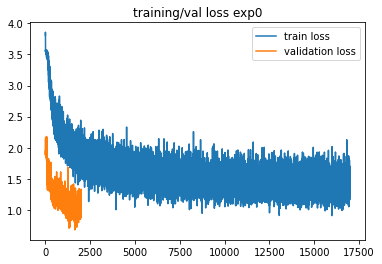

main program finished in  0:12:14.383110


In [5]:
%run main.py --model mel --COLAB --save_checkpoint 'mel' --num-epochs 20 

In [13]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

exp_name = 'nameless_exp'
PATH='mel.pt'
storage['training_mode']=True

Using cuda


## Downloading and setting up the dataset

In [21]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    #if 'train_set' not in locals():  
        #train_set = SubsetSC("training",root)
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = test_set[0]

batch_size = 100

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

training & test sets finished in  0:00:00.000003


## Let's visualize the data !

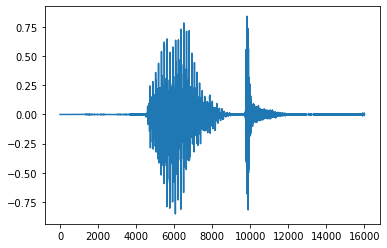

In [8]:
plt.plot(storage['waveform'].t().numpy())

In [10]:

n_mels=50
fe=16000
win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length 
spec_size=(fe -win_length)/hop_length +1
print('size of tensor should be ',spec_size)

size of tensor should be  98.0


### MFCC

Shape of spectrogram: torch.Size([1, 40, 101])


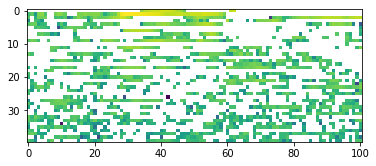

In [11]:
MFCC_transform = torchaudio.transforms.MFCC(melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    })
MFCC_spec=MFCC_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(MFCC_spec.size()))
waveform_size=MFCC_spec.shape
plt.figure()
p = plt.imshow(MFCC_spec.log2()[0].detach().numpy())

In [14]:
storage['model'] = mel_model(input_shape=waveform_size, n_output=len(test_set.labels))
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())
storage['model'].load_state_dict(torch.load( exp_name + '/' +  PATH))



Number of parameters: 355011


<All keys matched successfully>

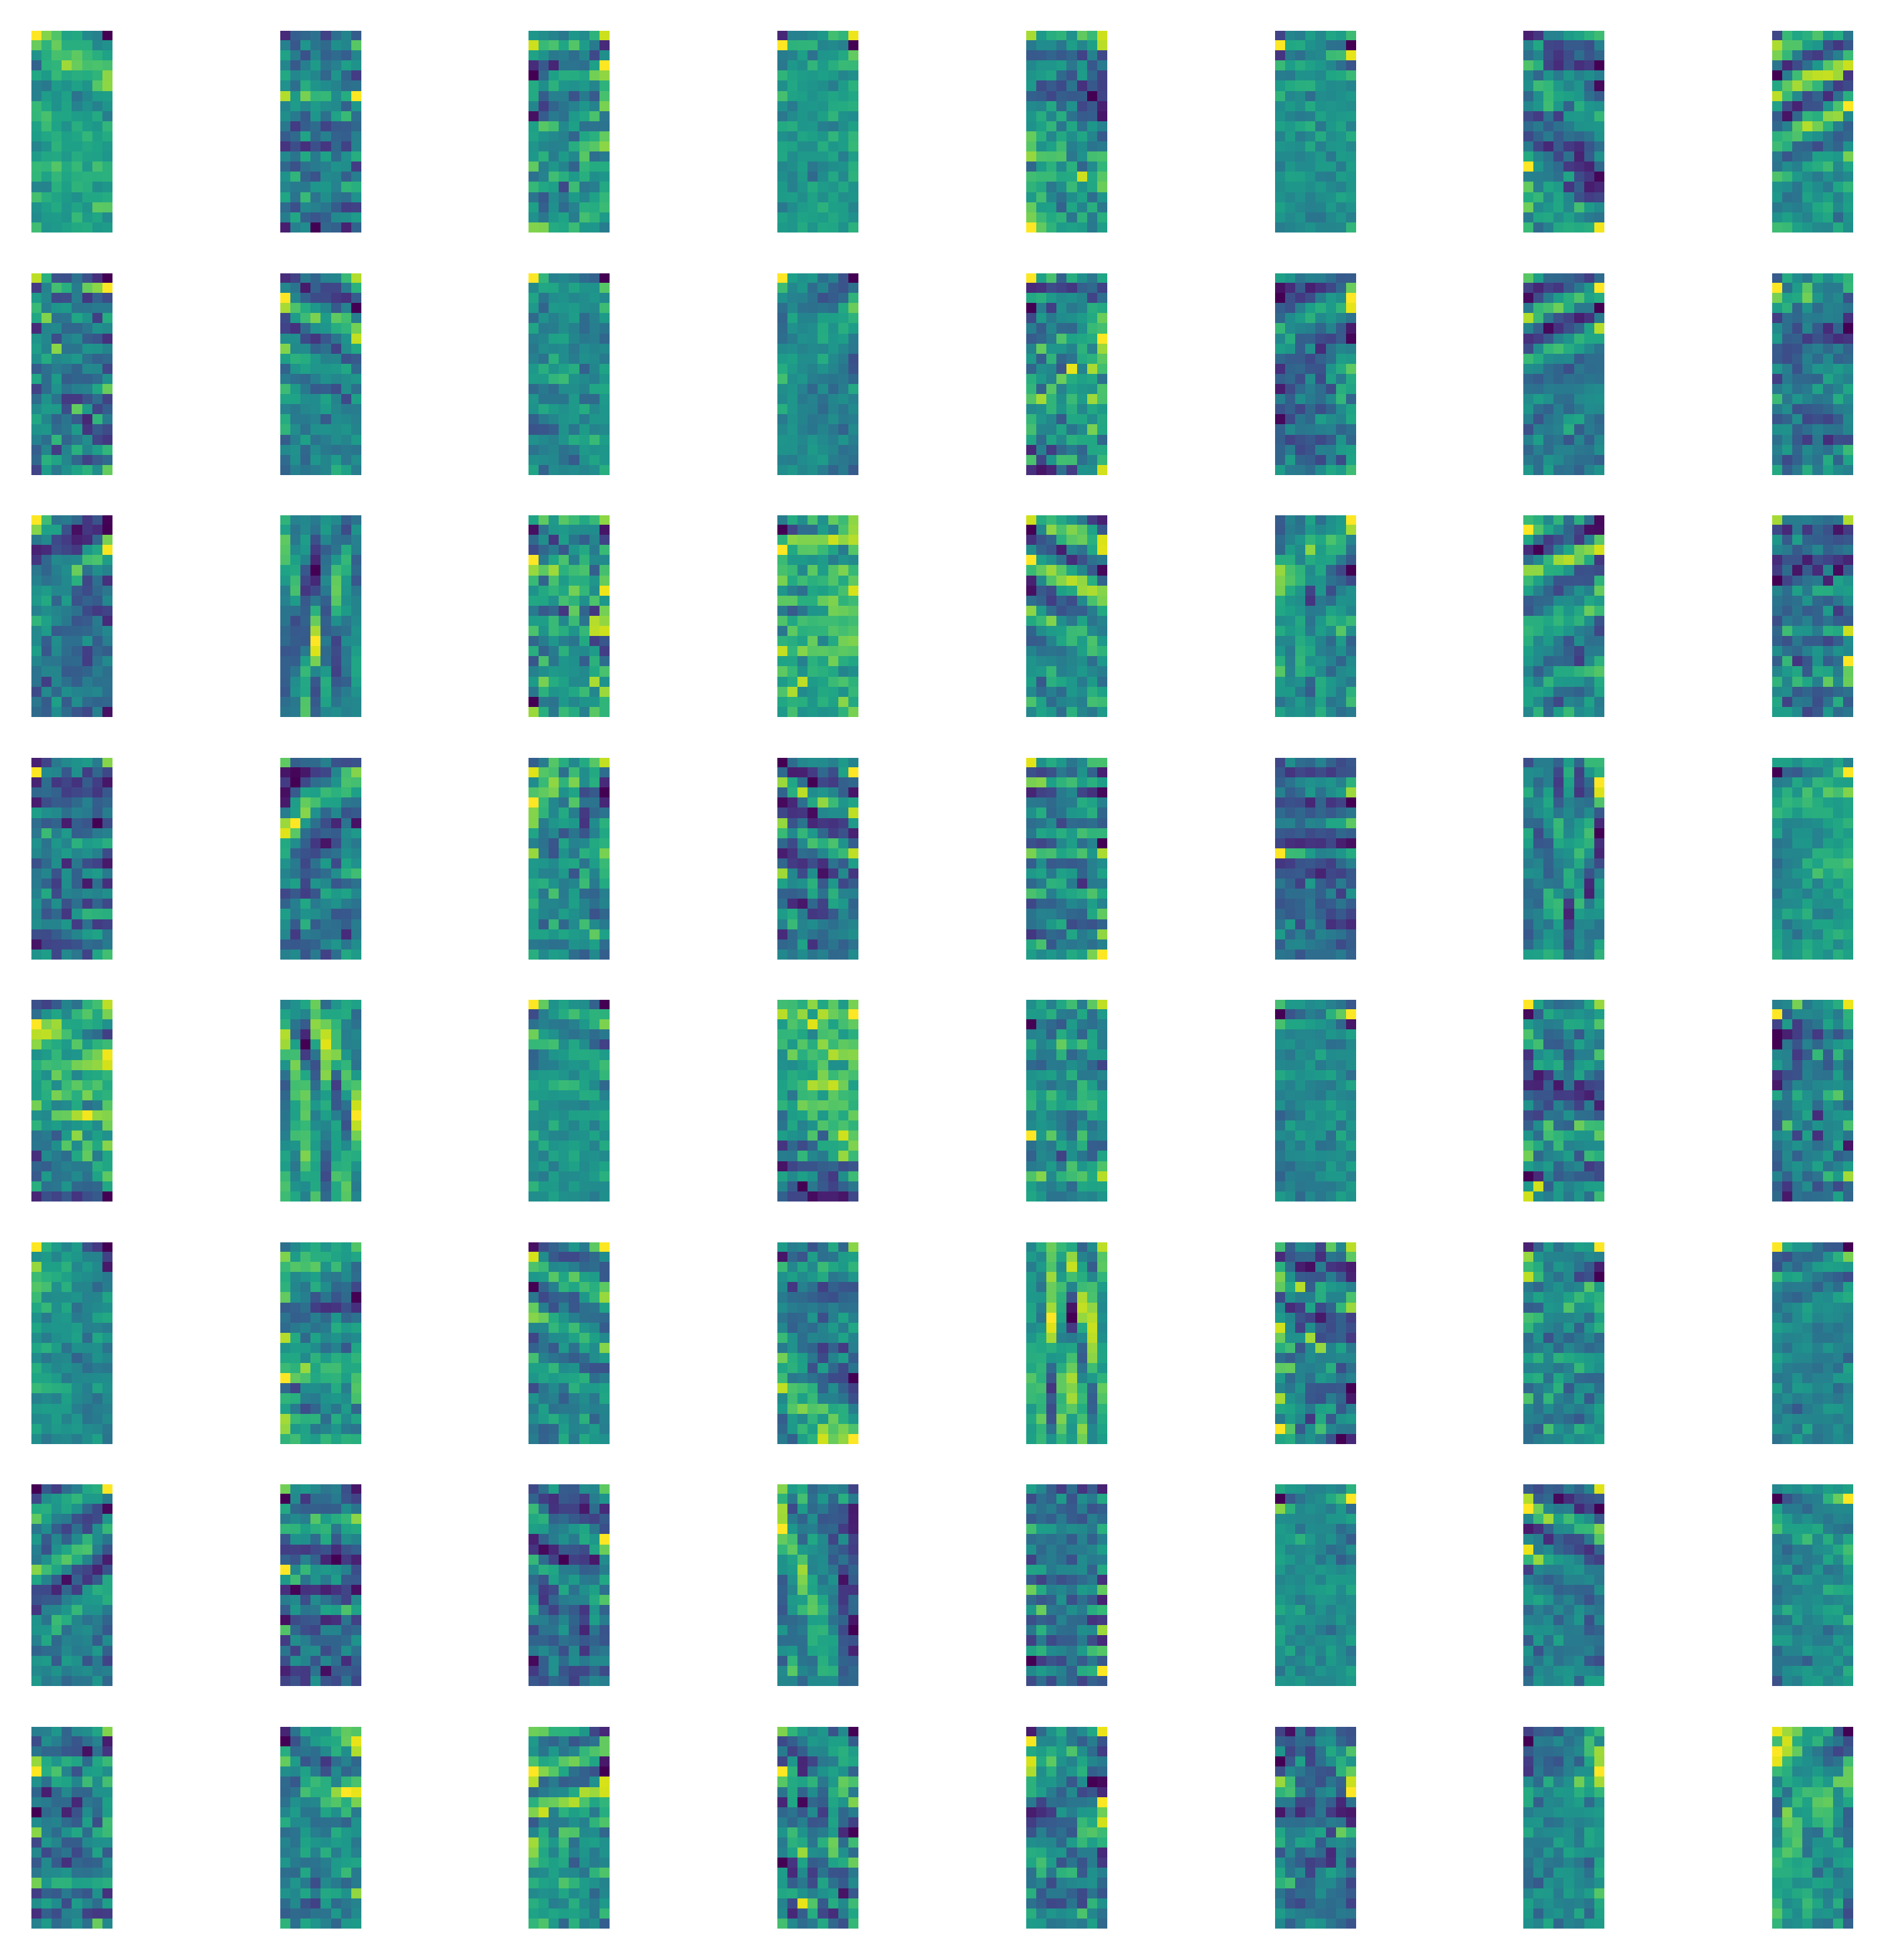

In [17]:
FirstLayerWeights = storage['model'].conv1[0].weight.detach().cpu().numpy()
plot_kernels2D(FirstLayerWeights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([64, 1, 21, 32])


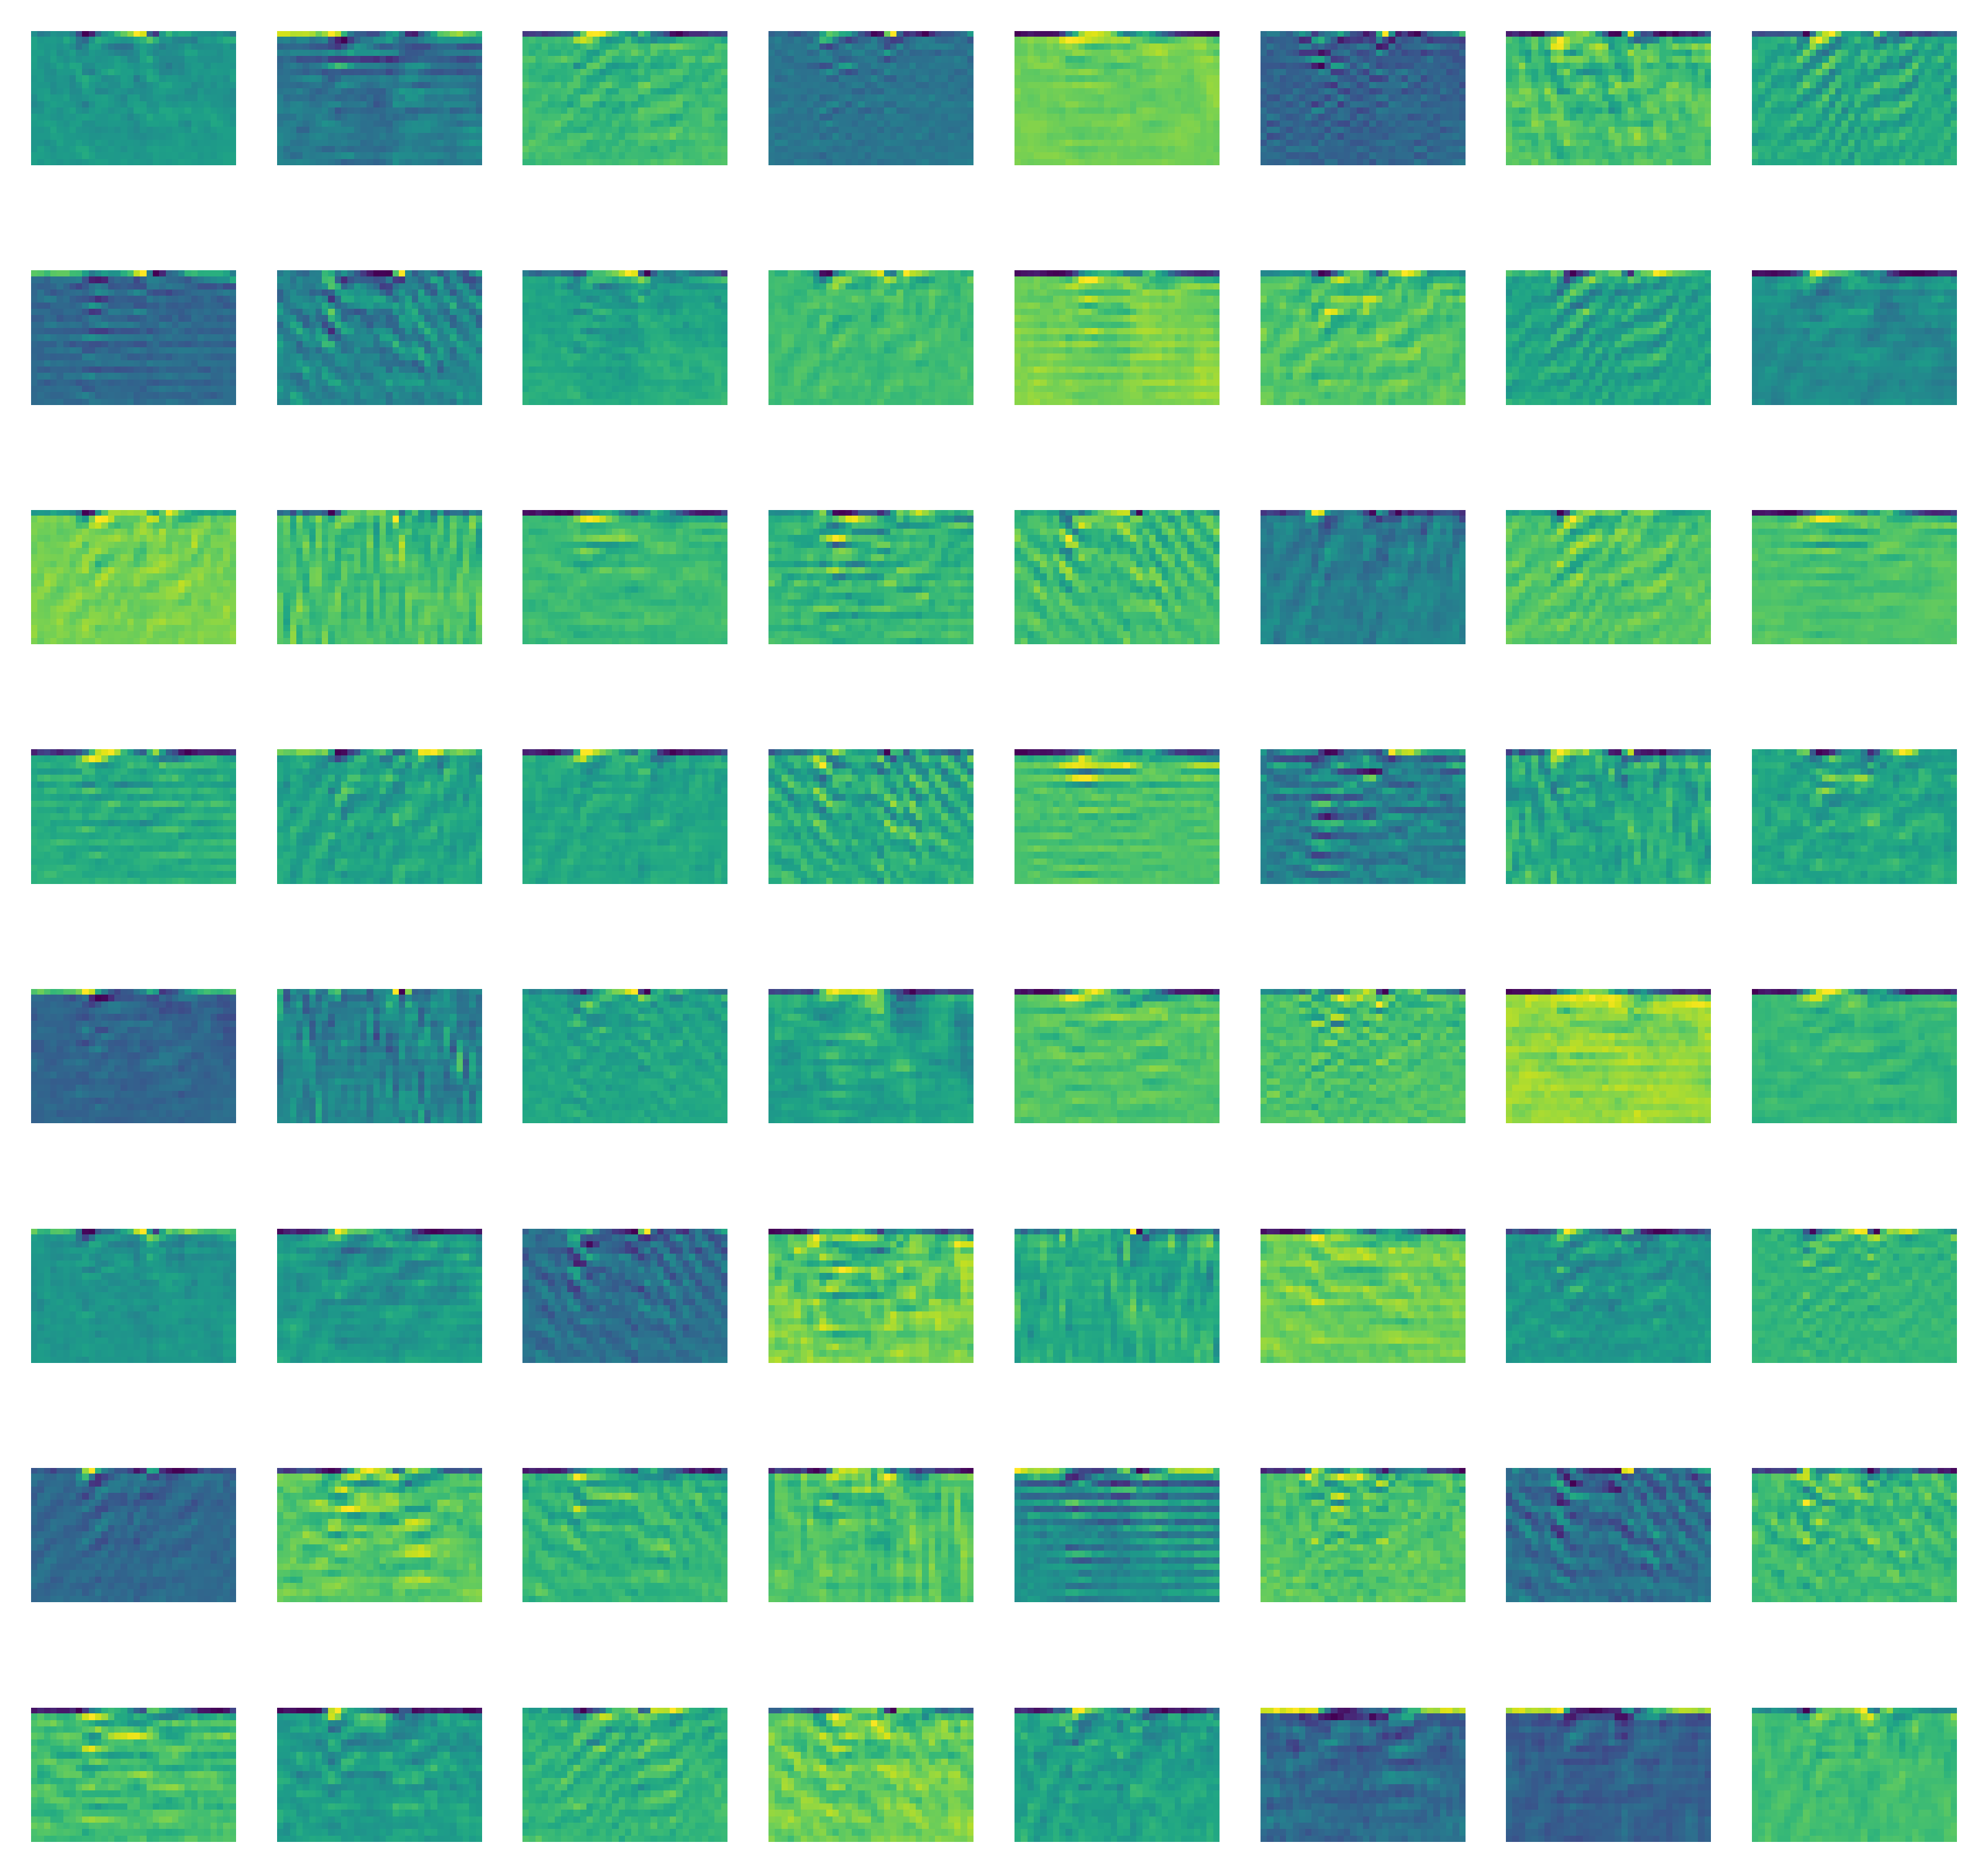

In [46]:
data= MFCC_transform ( torch.tensor ( storage['waveform'] ) )

featureMap =  storage['model'].conv1[0].to('cpu') (data) [:,None].detach()
print(featureMap.shape)
plot_kernels2D(featureMap)